# section 1

In [1]:
import sys
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install matplotlib.pyplot
# !{sys.executable} -m pip install scipy
# !{sys.executable} -m pip install statsmodels
# !{sys.executable} -m pip install scikit-learn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.integrate import quad
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df22 = pd.read_csv(r'C:\Users\rafae\OneDrive\Documentos\prog\coding\modelagem-estatistica\MICRODADOS_ENEM_2021.csv',  sep=';',encoding='iso-8859-1', usecols=["NU_ANO","TP_FAIXA_ETARIA","TP_SEXO",
                                                                                                                          "TP_COR_RACA","TP_ST_CONCLUSAO", 'TP_ANO_CONCLUIU', "TP_ESCOLA",
                                                                                                                          "NO_MUNICIPIO_PROVA","SG_UF_PROVA",
                                                                                                                          "NU_NOTA_COMP3", "NU_NOTA_REDACAO", "NU_NOTA_COMP1", "NU_NOTA_COMP4",
                                                                                                                          "Q001","Q002","Q003","Q004","Q005","Q006","Q022","Q025",
                                                                                                                          "NU_NOTA_LC", "NU_NOTA_CH", "NU_NOTA_MT", "NU_NOTA_CN"]).dropna()

In [3]:
# # computador fgv
# df22 = pd.read_csv(r'C:\Users\b47244\Documents\Modelagem-Estatistica\dados\MICRODADOS_ENEM_2021.csv',  sep=';',encoding='iso-8859-1', usecols=["NU_ANO","TP_FAIXA_ETARIA","TP_SEXO",
#                                                                                                                           "TP_COR_RACA","TP_ST_CONCLUSAO", 'TP_ANO_CONCLUIU', "TP_ESCOLA",
#                                                                                                                           "NO_MUNICIPIO_PROVA","SG_UF_PROVA",
#                                                                                                                           "NU_NOTA_COMP3", "NU_NOTA_REDACAO",
#                                                                                                                           "Q001","Q002","Q003","Q004","Q005","Q006","Q022","Q025"]).dropna()

Agora, iremos tratar esses dados:

In [4]:
# apenas quem nao zerou a competencia 3
df22 = df22[df22['NU_NOTA_COMP3']!=0]

# apenas quem nao zerou a competencia 3
df22 = df22[df22['NU_NOTA_REDACAO']!=0]

In [5]:
# Masculino = 1 e Feminino = 0
df22['TP_SEXO'] = df22['TP_SEXO'].replace('M',1).replace('F',0)

C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\1660209483.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df22['TP_SEXO'] = df22['TP_SEXO'].replace('M',1).replace('F',0)


In [6]:
# apenas quem declarou a etnia e criar dummies
df22 = df22[df22['TP_COR_RACA']!=0]
df22 = df22[df22['TP_COR_RACA']!=6]

print(len(df22))
print(df22['TP_COR_RACA'].value_counts())

df22 = pd.get_dummies(df22, columns=['TP_COR_RACA'], prefix='TP_COR_RACA')

2133238
TP_COR_RACA
1    959455
3    881544
2    238654
4     43716
5      9869
Name: count, dtype: int64


In [7]:
# Ao invés de usar o nome dos municipios, iremos verificar se o aluno fez a prova em uma capital
capitais = [
    'Rio Branco', 'Maceió', 'Macapá', 'Manaus', 'Salvador', 'Fortaleza', 
    'Brasília', 'Vitória', 'Goiânia', 'São Luís', 'Cuiabá', 'Campo Grande', 
    'Belo Horizonte', 'Belém', 'João Pessoa', 'Curitiba', 'Recife', 
    'Teresina', 'Rio de Janeiro', 'Natal', 'Porto Alegre', 'Porto Velho', 
    'Boa Vista', 'Florianópolis', 'São Paulo', 'Aracaju', 'Palmas'
]

df22['CAPITAL'] = df22['NO_MUNICIPIO_PROVA'].apply(lambda x: 1 if x in capitais else 0)
df22 = df22.drop('NO_MUNICIPIO_PROVA',axis=1)

In [8]:
# proporção de fora da capital é maior em índios
for i in range(1,6):   
    print(f"raça cor {i}: ", df22[df22[f"TP_COR_RACA_{i}"]== True]['CAPITAL'].sum()/len(df22[df22[f"TP_COR_RACA_{i}"]== True]))

raça cor 1:  0.301309597636158
raça cor 2:  0.3434218575846204
raça cor 3:  0.2999623388055503
raça cor 4:  0.32441211455759905
raça cor 5:  0.22950653561657716


In [9]:
# entendendo onde os indios estao
# esse conjunto de dados NAO é um pedaço que representa a população geral
# de indios. Note que PE é apenas o 4 estado com maior numero de indios no país.
print(df22[df22['TP_COR_RACA_5']== True]['SG_UF_PROVA'].value_counts())
print(df22['TP_SEXO'].value_counts())

SG_UF_PROVA
PE    1620
AM    1290
BA     897
SP     739
PB     588
PA     542
CE     483
MS     468
MG     439
RJ     319
MA     244
AL     229
GO     227
PI     190
RN     162
SE     159
RR     155
ES     150
MT     130
PR     118
RS     118
RO     118
TO     112
DF     106
AP      92
SC      90
AC      84
Name: count, dtype: int64
TP_SEXO
0    1321850
1     811388
Name: count, dtype: int64


In [10]:
# iremos usar dummies das regiões do país ao inves do nome dos estados para diminuir o numero de variaveis no modelo

regioes = {
    'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['GO', 'MT', 'MS', 'DF'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}

def mapear_regiao(uf):
    for regiao, ufs in regioes.items():
        if uf in ufs:
            return regiao
    return None
df22['Regiao'] = df22['SG_UF_PROVA'].apply(mapear_regiao)

df22 = df22.drop('SG_UF_PROVA',axis=1)
df22 = pd.get_dummies(df22, columns=['Regiao'], prefix='Regiao')

In [11]:
# a distribuição geografico de indios tambem difere bastante dos não indios
print(df22[df22['TP_COR_RACA_5']== True].loc[:,['Regiao_Centro-Oeste', 'Regiao_Nordeste', 'Regiao_Norte', 'Regiao_Sudeste', 'Regiao_Sul']].sum())
print("\n----------------\n")
print(df22[df22['TP_COR_RACA_5']== False].loc[:,['Regiao_Centro-Oeste', 'Regiao_Nordeste', 'Regiao_Norte', 'Regiao_Sudeste', 'Regiao_Sul']].sum())

Regiao_Centro-Oeste     931
Regiao_Nordeste        4572
Regiao_Norte           2393
Regiao_Sudeste         1647
Regiao_Sul              326
dtype: int64

----------------

Regiao_Centro-Oeste    180039
Regiao_Nordeste        744789
Regiao_Norte           217210
Regiao_Sudeste         739683
Regiao_Sul             241648
dtype: int64


In [12]:
# Q005 é sobre quantas pessoas moram na família e Q006 é sobre a renda mensal da familia (soma de cada um dos membros).
# Criaremos uma coluna que contabilize a renda per capita familiar

# Dicionário com as faixas salariais e seus valores numéricos
faixas_salarial = {
    'A': 0,
    'B': 1212,
    'C': 1818,
    'D': 2424,
    'E': 3030,
    'F': 3636,
    'G': 4848,
    'H': 6060,
    'I': 7272,
    'J': 8484,
    'K': 9696,
    'L': 10908,
    'M': 12120,
    'N': 14544,
    'O': 18180,
    'P': 24240,
    'Q': 24241  # Considerando acima de 24240
}

nova_faixa = {
    0: 0,
    1: 303,
    2: 606,
    3: 909,
    4: 1212,
    5: 1818,
    6: 2424,
    7: 3030,
    8: 3636,
    9: 4848,
    10: 6060,
    11: 9090,
    12: 9091, # valores acima de 9091 por pessoa
}

# Função para calcular a renda por pessoa e encontrar a faixa salarial correspondente
def calcular_faixa_renda_por_pessoa(pessoas, renda_familia):
    renda_total = faixas_salarial[renda_familia]
    renda_por_pessoa = renda_total / pessoas
    
    # Encontrar a faixa salarial correspondente
    for faixa, valor in nova_faixa.items():
        if renda_por_pessoa <= valor:
            return faixa
    return 12  # Para renda acima de R$ 9091,00 por pessoa

# Aplicar a função para calcular a faixa salarial da renda por pessoa
df22['renda_fam'] = df22.apply(lambda row: calcular_faixa_renda_por_pessoa(row['Q005'], row['Q006']), axis=1)


In [13]:
# Nota-se que a renda per capita por familia é menor em índios. Proporcionalmente, existem mais individuos com nenhuma renda.
# Isso também motiva a fazer o matching
print(df22['Q005'].value_counts())
print(df22['Q006'].value_counts())
print(df22['renda_fam'].value_counts())
print('-------------')
print(df22[df22['TP_COR_RACA_5']== True]['Q005'].value_counts())
print(df22[df22['TP_COR_RACA_5']== True]['Q006'].value_counts())
print(df22[df22['TP_COR_RACA_5']== True]['renda_fam'].value_counts())

df22 = df22.drop('Q005',axis=1)
df22 = df22.drop('Q006',axis=1)

Q005
4.0     760937
3.0     585561
5.0     324892
2.0     255881
6.0     101682
1.0      45417
7.0      34532
8.0      13776
9.0       5132
10.0      2948
11.0      1008
12.0       656
13.0       277
14.0       164
20.0       127
15.0       112
16.0        55
18.0        31
17.0        29
19.0        21
Name: count, dtype: int64
Q006
B    512777
C    330108
D    265545
F    161651
G    142463
E    137966
H    114816
A    103651
I     73046
M     46402
J     45524
Q     38832
K     35994
P     31908
O     31878
L     31559
N     29118
Name: count, dtype: int64
renda_fam
2     654964
1     308509
3     272855
4     242832
5     184460
6     123744
0     103651
7      64891
9      49902
8      44821
11     40150
10     36957
12      5502
Name: count, dtype: int64
-------------
Q005
4.0     2757
3.0     2051
5.0     1900
2.0     1034
6.0      922
7.0      427
1.0      262
8.0      224
9.0      133
10.0      71
12.0      31
11.0      27
13.0      11
14.0       7
15.0       4
16.0       3
18

In [14]:
# print(df22)
print(df22.loc[:,['TP_COR_RACA_1', 'TP_COR_RACA_2', 'TP_COR_RACA_3', 'TP_COR_RACA_4', 'TP_COR_RACA_5']].sum())
print(df22['Q001'].value_counts())
print(df22['Q002'].value_counts())

# escolaridade da mae tende ser maior

TP_COR_RACA_1    959455
TP_COR_RACA_2    238654
TP_COR_RACA_3    881544
TP_COR_RACA_4     43716
TP_COR_RACA_5      9869
dtype: int64
Q001
E    654307
B    330607
C    267453
F    238570
D    233992
G    177759
H    159870
A     70680
Name: count, dtype: int64
Q002
E    761069
F    310041
G    299371
D    232857
B    228972
C    213568
A     44049
H     43311
Name: count, dtype: int64


In [15]:
# apenas quem sabe a escolaridade do pai OU da mãe
df22 = df22.loc[(df22['Q001'] != 'H') | (df22['Q002'] != 'H')]

# apenas quem sabe a profissão do pai OU da mãe
df22 = df22[~((df22['Q003'] == 'F') & (df22['Q004'] == 'F'))]

# Aplicar a função de conversão apenas para as colunas com letras
def letra_num(letra):
    return ord(letra) - ord('A')

for col in ['Q001', 'Q002', 'Q003', 'Q004', 'Q022', 'Q025']:
    df22[col] = df22[col].apply(letra_num)

# substituimos os valores de quem não sabe para não alterar o max
df22[['Q001', 'Q002']] = df22[['Q001', 'Q002']].replace(7,-1)
df22[['Q003', 'Q004']] = df22[['Q003', 'Q004']].replace(5,-1)

# escolhemos o responsável com maior escolaridade e o com "maior emprego"
df22['maior_escolaridade'] = df22[['Q001', 'Q002']].max(axis=1)
df22['maior_emprego'] = df22[['Q003', 'Q004']].max(axis=1)

df22= df22.drop(['Q001', 'Q002', 'Q003', 'Q004'],axis=1)


In [16]:
# print(df22)
print(df22.loc[:,['TP_COR_RACA_1', 'TP_COR_RACA_2', 'TP_COR_RACA_3', 'TP_COR_RACA_4', 'TP_COR_RACA_5']].sum())
print(df22['maior_emprego'].value_counts())
print(df22['maior_escolaridade'].value_counts())

TP_COR_RACA_1    932074
TP_COR_RACA_2    229649
TP_COR_RACA_3    846255
TP_COR_RACA_4     42039
TP_COR_RACA_5      9400
dtype: int64
maior_emprego
3    722514
1    467117
2    398994
4    244363
0    226429
Name: count, dtype: int64
maior_escolaridade
4    757762
6    380265
5    350529
3    201434
1    172678
2    171937
0     24812
Name: count, dtype: int64


In [17]:
df22.loc[:, 'TP_FAIXA_ETARIA'] = df22['TP_FAIXA_ETARIA'] - 1
# df22['TP_FAIXA_ETARIA'] = df22['TP_FAIXA_ETARIA'].apply(lambda x: 1 if x < 2 else x) # menores de 18
# df22['TP_FAIXA_ETARIA'] = df22['TP_FAIXA_ETARIA'].apply(lambda x: 3 if x == 3 or x == 4 else x) # 19 - 20 anos
# df22['TP_FAIXA_ETARIA'] = df22['TP_FAIXA_ETARIA'].apply(lambda x: 4 if x == 5 or x == 6 or x == 7 else x) # 21 - 23 anos
# df22['TP_FAIXA_ETARIA'] = df22['TP_FAIXA_ETARIA'].apply(lambda x: 5 if x == 8 or x == 9 or x == 10 else x) # 24 - 30 anos
# df22['TP_FAIXA_ETARIA'] = df22['TP_FAIXA_ETARIA'].apply(lambda x: 6 if x > 10 else x) # 31+
# print(df22['TP_FAIXA_ETARIA'].value_counts())

# section 2

Analisando os dados, percebi que apenas quem irá concluir o EM em 2022 que informou o tipo de escola que estudou (pública ou privada). Por isso, criei um segundo dataframe para analisar apenas esse grupo. No primeiro dataframe analiasaremos os dois grupos e poderemos ver como o ano de conclusão influencia no nota final.

In [18]:
# Apenas quem irá concluir o EM no ano da prova que informou o tipo de escola. 
# Por isso nesse df analisaremos o impacto do tipo de escola na nota final.
# pública = 0 e privada = 1
df22_2 = df22.copy()
df22_2 = df22[df22['TP_ST_CONCLUSAO']==2]
df22_2.loc[:, 'TP_ESCOLA'] = df22['TP_ESCOLA'] - 2

print(df22_2['TP_ESCOLA'].value_counts())

TP_ESCOLA
 0    600097
 1    171078
-1         2
Name: count, dtype: int64


In [19]:
# Pessoas que já se formaram nao identificaram o tipo de escola que estudaram (se publica ou privada).
# Logo criamos um df para podermos verificar se a quantidade de tempo desde que ela concluiu o EM influenciou no seu resultado

df22 = df22[(df22['TP_ST_CONCLUSAO'] == 1) | (df22['TP_ST_CONCLUSAO'] == 2)]

# excluimos quem já concluiu o EM e não informou o ano que concluiu o EM
df22 = df22.drop(df22[(df22['TP_ST_CONCLUSAO'] == 1) & (df22['TP_ANO_CONCLUIU'] == 0)].index)

In [20]:
# removemos a coluna do status de conclusao no DFs 1 e 2
df22 = df22.drop('TP_ST_CONCLUSAO',axis=1)
df22_2 = df22_2.drop('TP_ST_CONCLUSAO',axis=1)

In [21]:
# removemos a coluna de ano de conclusão do DF 2
df22_2 = df22_2.drop('TP_ANO_CONCLUIU',axis=1)

In [22]:
# removemos a coluna do tipo de escola do DF 1
df22 = df22.drop('TP_ESCOLA',axis=1)


In [23]:
# Reiniciar os índices
df22.reset_index(drop=True, inplace=True)
df22_2.reset_index(drop=True, inplace=True)

# trocar booleanos
df22 = df22*1
df22_2 = df22_2*1

Agora, vamos fazer o matching. É esperado que reduza vieses, uma vez que igualamos as situações socieconômicas. As correlações entre variáveis socioeconômicas e notas de redação devem ser mais próximas entre indígenas e não indígenas após o matching, refletindo a equiparação das condições de base (de fato foi o observado).

Os indigenas parecem ser diferentes da população geral: menor acesso a internet, menor presença em capitais, esoclaridade (?). Além disso, tem uma diferença de dados muito grande entre indigenas e nao indigenas. Portanto, as analises devem se mostrar mais claras após o matching

In [24]:
df22 = df22_2.copy()
print(df22.columns)

Index(['NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESCOLA', 'NU_NOTA_CN',
       'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_COMP1',
       'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_REDACAO', 'Q022', 'Q025',
       'TP_COR_RACA_1', 'TP_COR_RACA_2', 'TP_COR_RACA_3', 'TP_COR_RACA_4',
       'TP_COR_RACA_5', 'CAPITAL', 'Regiao_Centro-Oeste', 'Regiao_Nordeste',
       'Regiao_Norte', 'Regiao_Sudeste', 'Regiao_Sul', 'renda_fam',
       'maior_escolaridade', 'maior_emprego'],
      dtype='object')


In [25]:
# Filtrar os dados para incluir apenas os indígenas e os não indígenas
dados_indigenas = df22[df22['TP_COR_RACA_5'] == True].copy()
dados_nao_indigenas = df22[df22['TP_COR_RACA_5'] == False].copy()

# Selecionar as colunas relevantes para o matching
colunas_relevantes = [
    'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESCOLA',
    'Q022', 'Q025', 'renda_fam',
    'maior_escolaridade', 'maior_emprego', 
    'CAPITAL'
]

# Adicionar uma coluna de ID para identificar cada indígena e não indígena único
dados_indigenas['indigena_id'] = dados_indigenas.index
dados_nao_indigenas['nao_indigena_id'] = dados_nao_indigenas.index

# Realizar um merge completo para encontrar todos os possíveis matches
merged = pd.merge(dados_indigenas, dados_nao_indigenas, on=colunas_relevantes, how='left', suffixes=('_indigena', '_nao_indigena')).dropna()

# Inicializar conjuntos para manter rastreamento de matches únicos
matches = []
nao_indigenas_usados = set()

# Iterar sobre cada indígena
for indio_id in dados_indigenas['indigena_id']:
    possiveis_matches = merged[merged['indigena_id'] == indio_id]
    
    for _, row in possiveis_matches.iterrows():
        nao_indigena_id = row['nao_indigena_id']
        if nao_indigena_id not in nao_indigenas_usados:
            matches.append(indio_id)
            matches.append(nao_indigena_id)
            nao_indigenas_usados.add(nao_indigena_id)
            break

# Exibir o número de matches encontrados
print(f"Número de indígenas: {len(dados_indigenas)}")
print(f"Número de matches encontrados: {len(matches)/2}")
indigenas_sem_matches = dados_indigenas[~dados_indigenas['indigena_id'].isin(matches)] # em geral sao indigenas isolados, ou seja,
# sem acesso a internet, com poucos ou nenhum telefones celulares em casa

Número de indígenas: 3538
Número de matches encontrados: 3399.0


In [26]:
print(len(dados_nao_indigenas))
print(len(dados_indigenas))

767639
3538


In [27]:
print(indigenas_sem_matches['renda_fam'].value_counts())

renda_fam
1     45
0     27
2     26
3     17
4      7
5      5
6      4
11     2
9      2
10     1
7      1
8      1
12     1
Name: count, dtype: int64


In [28]:
# atualizando o df
df22_sem_match = df22.copy()
df22 = df22[df22.index.isin(matches)]

analisando a matriz de correlação notamos que as variaveis mais importantes para a nota da redação (ou da competencia 3) são Q022, Q025, faixa per capita da familia, responsavel com maior escolaridade e responsavel com maior emprego. A média e o desvio padrao desses valores tendem a ter resultados similares ao longo dos anos analisados.

Um ponto importante a destacar é que a variavel sobre acesso a internet (Q025) teve uma leve mudança na sua distribuição ao longo dos anos, algo que não foi observado nas outras variaveis

In [29]:
df22.describe()

,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_COMP1,NU_NOTA_COMP3,...,TP_COR_RACA_5,CAPITAL,Regiao_Centro-Oeste,Regiao_Nordeste,Regiao_Norte,Regiao_Sudeste,Regiao_Sul,renda_fam,maior_escolaridade,maior_emprego
count,6798.0,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,...,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000
mean,2021.0,1.967049,0.404531,0.050309,459.761665,487.367520,471.939556,494.086055,115.675199,112.791998,...,0.500000,0.205060,0.120182,0.489997,0.158576,0.181083,0.050162,1.878788,3.541336,1.581936
std,0.0,1.351149,0.490837,0.218598,67.224216,82.866414,71.173939,90.917451,25.996828,28.416105,...,0.500037,0.403775,0.325199,0.499937,0.365307,0.385115,0.218295,1.570103,1.516710,1.241826
min,2021.0,0.000000,0.000000,0.000000,340.100000,0.000000,298.900000,0.000000,20.000000,20.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2021.0,1.000000,0.000000,0.000000,409.900000,423.325000,419.400000,424.000000,100.000000,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000
50%,2021.0,2.000000,0.000000,0.000000,450.200000,479.850000,473.000000,473.000000,120.000000,120.000000,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.000000,1.000000
75%,2021.0,2.000000,1.000000,0.000000,500.900000,545.175000,522.150000,546.200000,120.000000,120.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,4.000000,3.000000
max,2021.0,15.000000,1.000000,1.000000,743.700000,811.300000,734.700000,926.600000,200.000000,200.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000,6.000000,4.000000


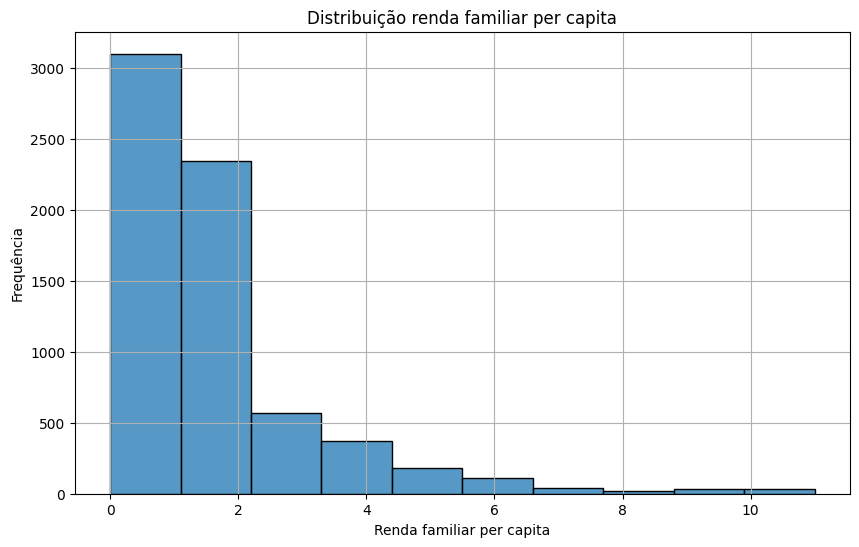

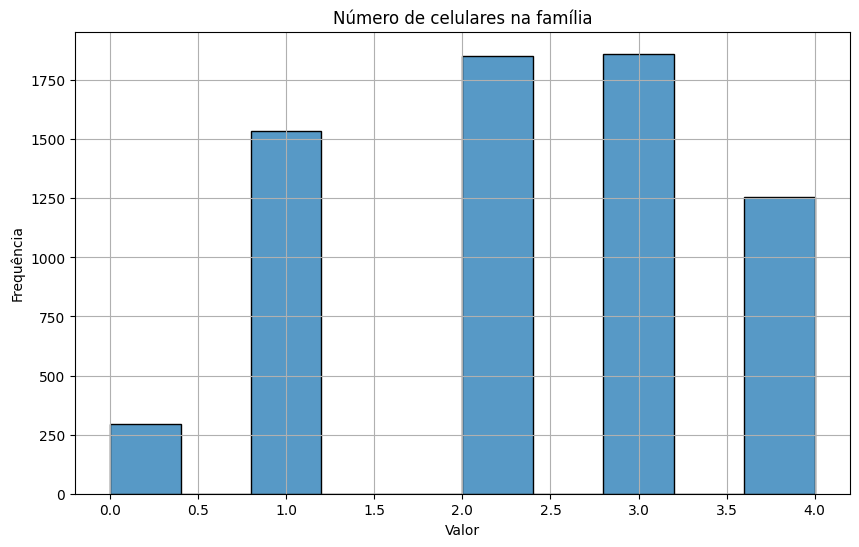

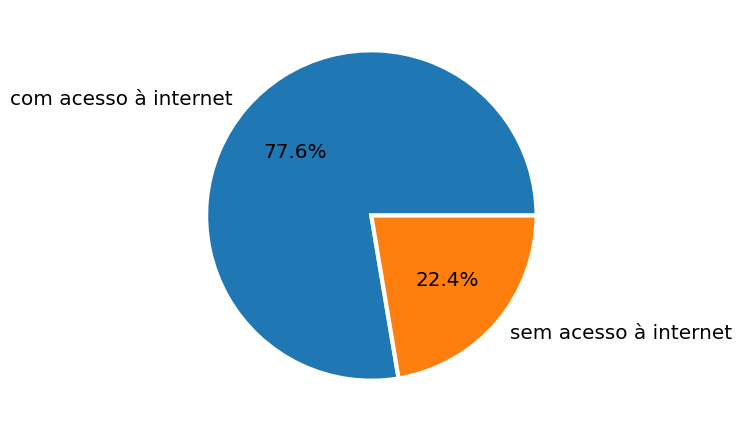

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(df22['renda_fam'], bins=10, kde=False)
plt.title('Distribuição renda familiar per capita')
plt.xlabel('Renda familiar per capita')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df22['Q022'], bins=10, kde=False)
plt.title('Número de celulares na família')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

plt.pie([df22['Q025'].sum(), len(df22) - df22['Q025'].sum()], labels = ['com acesso à internet', 'sem acesso à internet'], autopct='%.1f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
plt.tight_layout()

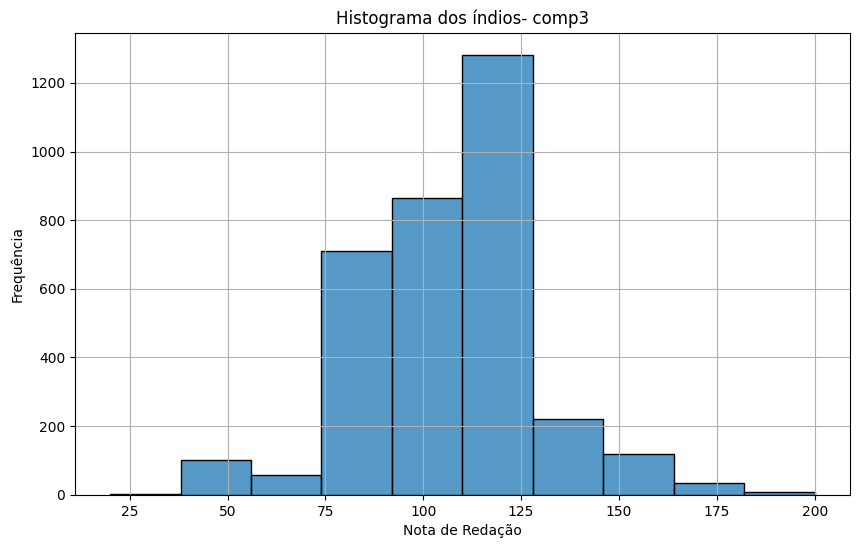

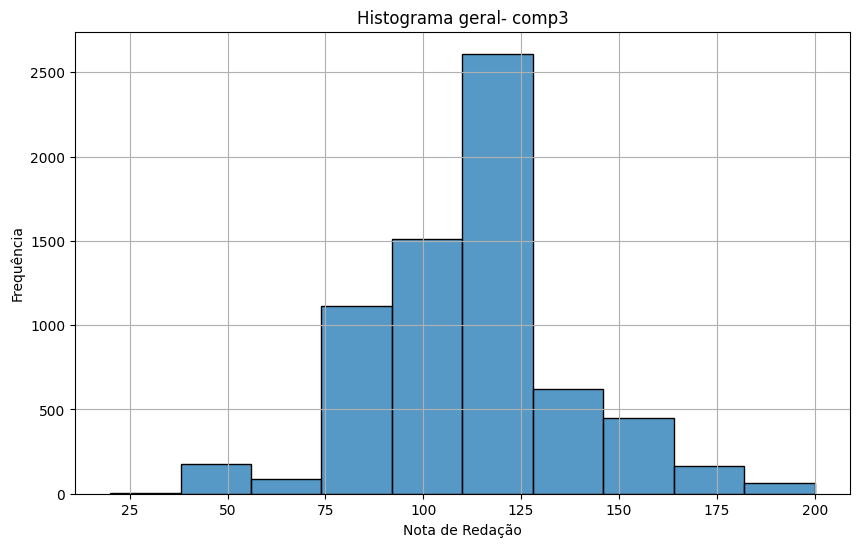

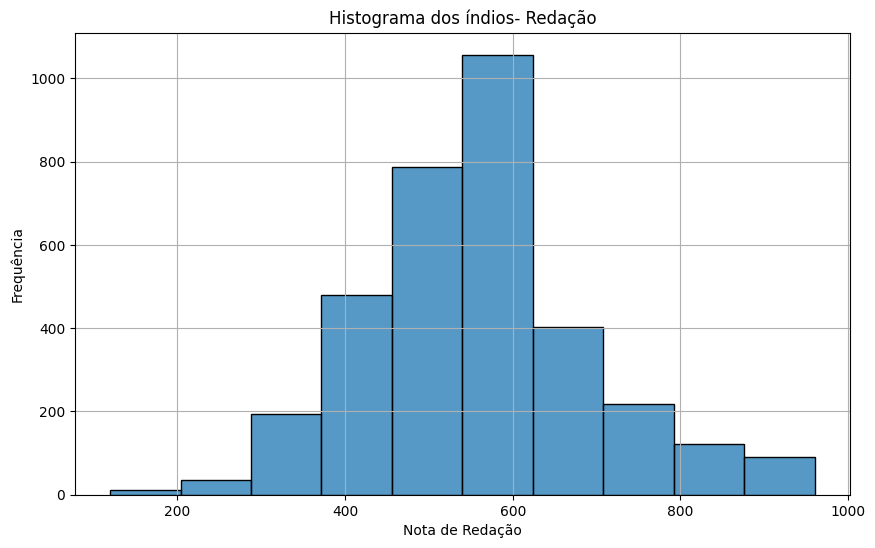

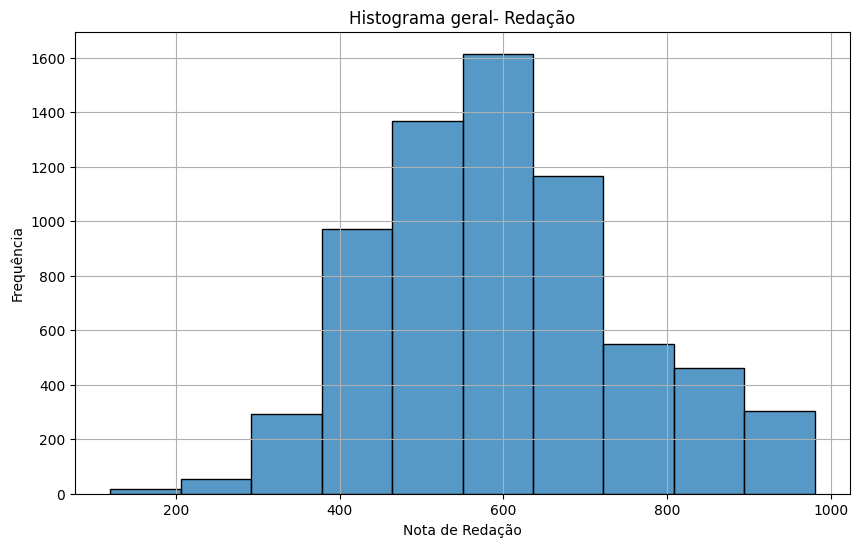

In [31]:
# apenas vendo se as notas seguem uma normal
# A nota da comp3 segue melhor a normal, entao usaremos ela para modelagem

def nota_grupo(dados_grupo, info, nota):
    plt.figure(figsize=(10, 6))
    # sns.kdeplot(dados_grupo['NU_NOTA_COMP3'], bw_adjust=2)
    sns.histplot(dados_grupo[nota], bins=10, kde=False)
    plt.title(info)
    plt.xlabel('Nota de Redação')
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.show()

nota_grupo(df22[df22['TP_COR_RACA_5']== True], 'Histograma dos índios- comp3', 'NU_NOTA_COMP3')
nota_grupo(df22, 'Histograma geral- comp3', 'NU_NOTA_COMP3')
nota_grupo(df22[df22['TP_COR_RACA_5']== True], 'Histograma dos índios- Redação', 'NU_NOTA_REDACAO')
nota_grupo(df22, 'Histograma geral- Redação', 'NU_NOTA_REDACAO')

In [32]:
media_geral = df22['NU_NOTA_REDACAO'].mean()
print(f"indigenas que tiraram acima da média:  {dados_indigenas['NU_NOTA_REDACAO'].gt(media_geral).sum()/len(df22)}")
print(f"nao indigenas que tiraram acima da média:  {dados_nao_indigenas['NU_NOTA_REDACAO'].gt(media_geral).sum()/len(df22)}")


indigenas que tiraram acima da média:  0.17990585466313622
nao indigenas que tiraram acima da média:  66.28729037952338


(analisando pre matching) Nota-se que a cada ano a diferença entre as curvas parece ser menor. O ano de 23 teve uma diferença significativamente menor que 21, apesar do tema raça/cor não ser algo relevante em ambos os anos, no que tange à própria prova. Vários fatores que aqui não conseguem ser medidos podem explicar essa redução da diferença da area entre as curvas ao longo dos anos: 
* **Redução da disparidade digital**: Tanto o aumento do acesso à internet quanto a melhoria da qualidade da internet em regiões afastadas contribuem para a redução da disparidade digital entre estudantes indígenas e não-indígenas. Isso pode ter permitido uma melhor preparação para a redação, especialmente para aqueles que anteriormente não tinham acesso a esses recursos. Indigenas, quando comparado a nao-indigenas, costumam morar em locais mais afastados, além de ter menor acesso a internet.

(pre x pos-matching) A diferença entre as curvas de indios e nao indios foi menor no ano de 22 e, alem disso, nota-se que essa diferença foi ainda mais reduzida após o matching. Esse maior impacto do matching em 2022 pode indicar que há fatores específicos nesse ano que influenciaram de maneira diferente a distribuição das notas de redação entre os grupos indígenas e não-indígenas. Nos outros anos, podemos observar que o matching nao teve um impacto significativo na área da diferença entre as curvas. O tema de 2022 sobre comunidades tradicionais pode ter sido particularmente relevante para os estudantes indígenas, mais do que para os não-indígenas. Isso pode ter reduzido as diferenças nas habilidades de redação quando os fatores sociais foram controlados pelo matching. Em outras palavras, o tema pode ter nivelado o campo de jogo de uma maneira que os outros temas de 2021 e 2023 não fizeram.

Os resultados indicam que o tema de redação de 2022 teve um impacto particular nas notas dos estudantes indígenas, sugerindo que temas culturalmente relevantes podem ajudar a reduzir disparidades de desempenho em avaliações. O matching exato reforça a validade dessas observações, mostrando que as características sociais foram bem balanceadas, e as diferenças observadas são atribuíveis principalmente ao tema da redação.

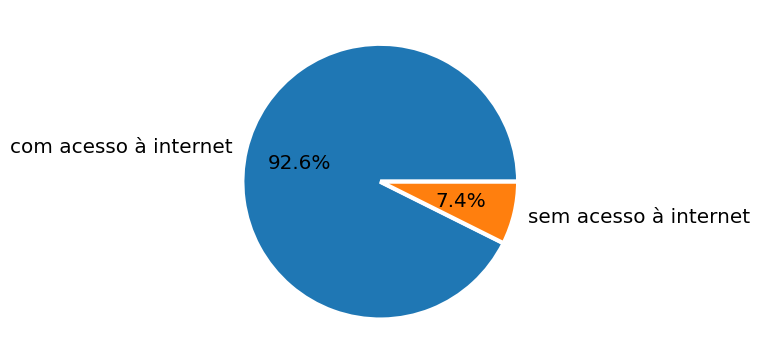

In [33]:
plt.pie([df22_sem_match[df22_sem_match['TP_COR_RACA_5'] == False]['Q025'].sum(), len(df22_sem_match[df22_sem_match['TP_COR_RACA_5'] == False]) - df22_sem_match[df22_sem_match['TP_COR_RACA_5'] == False]['Q025'].sum()], labels = ['com acesso à internet', 'sem acesso à internet'], autopct='%.1f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
plt.tight_layout()

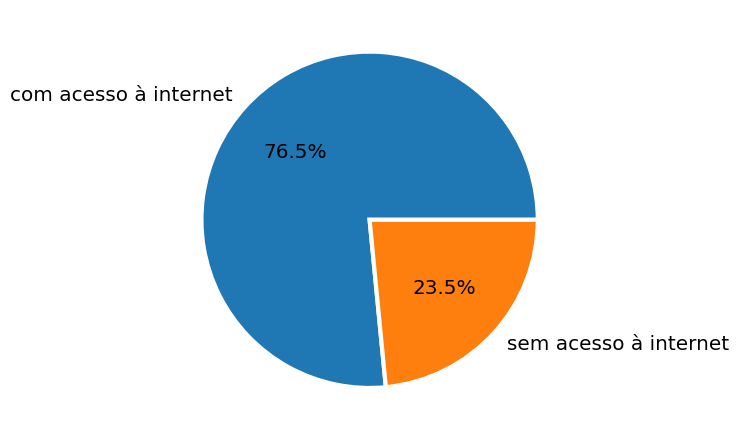

In [34]:
plt.pie([df22_sem_match[df22_sem_match['TP_COR_RACA_5'] == True]['Q025'].sum(), len(df22_sem_match[df22_sem_match['TP_COR_RACA_5'] == True]) - df22_sem_match[df22_sem_match['TP_COR_RACA_5'] == True]['Q025'].sum()], labels = ['com acesso à internet', 'sem acesso à internet'], autopct='%.1f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
plt.tight_layout()

A consistência das áreas antes e depois do ponto de interseção ao longo dos anos (tanto com quanto sem matching) sugere que há um padrão estável nas distribuições de notas de redação entre indígenas e não-indígenas. Este padrão é alterado apenas marginalmente pelo tema da redação de 2022, o que reforça a ideia de que o tema pode ter sido particularmente relevante para os indígenas.

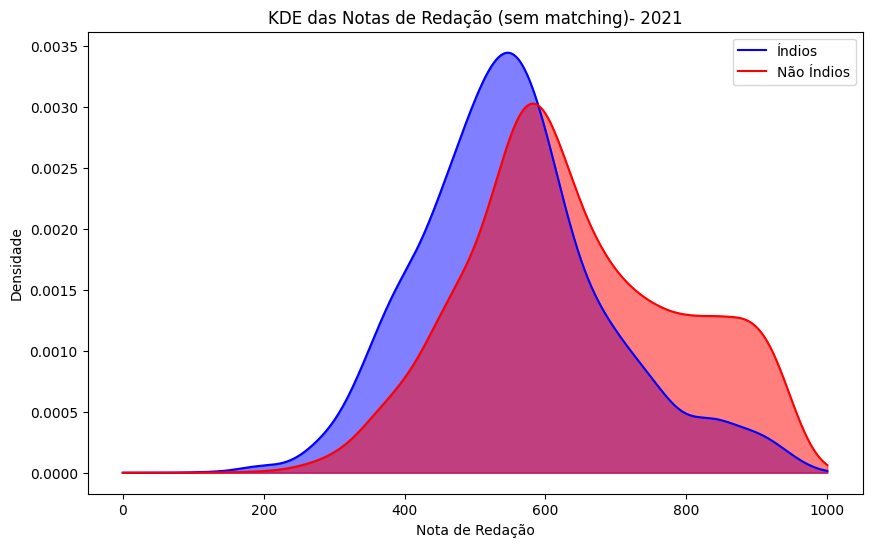

Crossing Point: 589.59
Area Before: 0.237
Area After: 0.236


C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\3599071698.py:42: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  area_before = quad(area_between_curves, 0, crossing_point, args=(kde_nao_indios_interp, kde_indios_interp))[0]
C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\3599071698.py:43: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  area_after = quad(area_between_curves, crossing_point, 1000, args=(kde_nao_indios_interp, kde_indios_interp))[0]


In [35]:
kde_indios = gaussian_kde(df22_sem_match[df22_sem_match['TP_COR_RACA_5'] == True]['NU_NOTA_REDACAO'])
kde_nao_indios = gaussian_kde(df22_sem_match[df22_sem_match['TP_COR_RACA_5'] == False]['NU_NOTA_REDACAO'], bw_method=0.15)

# Gerar valores para o eixo x
x_vals = np.linspace(0, 1000, 1000)

# Calcular as densidades KDE
kde_indios_data = kde_indios(x_vals)
kde_nao_indios_data = kde_nao_indios(x_vals)

# Interpolação das curvas KDE
kde_indios_interp = interp1d(x_vals, kde_indios_data, bounds_error=False, fill_value="extrapolate")
kde_nao_indios_interp = interp1d(x_vals, kde_nao_indios_data, bounds_error=False, fill_value="extrapolate")

# Plotar as curvas KDE
plt.figure(figsize=(10, 6))
plt.plot(x_vals, kde_indios_data, color='blue', label='Índios')
plt.plot(x_vals, kde_nao_indios_data, color='red', label='Não Índios')
plt.fill_between(x_vals, kde_indios_data, alpha=0.5, color='blue')
plt.fill_between(x_vals, kde_nao_indios_data, alpha=0.5, color='red')
plt.title('KDE das Notas de Redação (sem matching)- 2021')
plt.xlabel('Nota de Redação')
plt.ylabel('Densidade')
plt.legend()
plt.show()

# Função para calcular a área entre as curvas
def area_between_curves(x, kde1, kde2):
    return abs(kde1(x) - kde2(x))

# Encontrar o ponto de cruzamento no intervalo relevante (notas entre 0 e 1000)
diffs = kde_nao_indios_interp(x_vals) - kde_indios_interp(x_vals)
crossing_points = x_vals[np.where(np.diff(np.sign(diffs)))[0]]

if len(crossing_points) == 0:
    print('No crossing points found in the range.')
else:
    crossing_point = crossing_points[1]  # Usar o primeiro ponto de cruzamento relevante
    print(f'Crossing Point: {crossing_point:.2f}')

    # Calcular área antes e depois do ponto de cruzamento
    area_before = quad(area_between_curves, 0, crossing_point, args=(kde_nao_indios_interp, kde_indios_interp))[0]
    area_after = quad(area_between_curves, crossing_point, 1000, args=(kde_nao_indios_interp, kde_indios_interp))[0]

    print(f'Area Before: {area_before:.3f}')
    print(f'Area After: {area_after:.3f}')

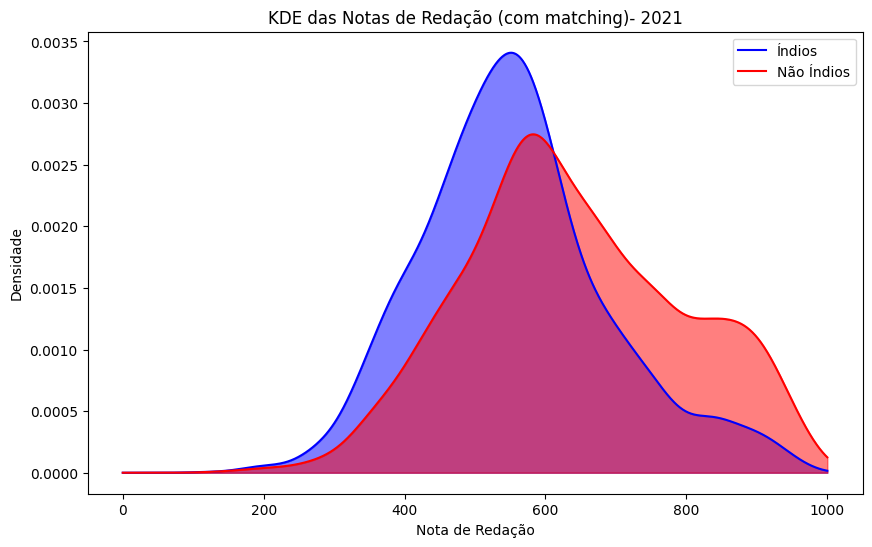

Crossing Point: 610.61
Area Before: 0.237
Area After: 0.235


C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\4242725243.py:42: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  area_before = quad(area_between_curves, 0, crossing_point, args=(kde_nao_indios_interp, kde_indios_interp))[0]
C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\4242725243.py:43: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  area_after = quad(area_between_curves, crossing_point, 1000, args=(kde_nao_indios_interp, kde_indios_interp))[0]


In [36]:
kde_indios = gaussian_kde(df22[df22['TP_COR_RACA_5'] == True]['NU_NOTA_REDACAO'])
kde_nao_indios = gaussian_kde(df22[df22['TP_COR_RACA_5'] == False]['NU_NOTA_REDACAO'])

# Gerar valores para o eixo x
x_vals = np.linspace(0, 1000, 1000)

# Calcular as densidades KDE
kde_indios_data = kde_indios(x_vals)
kde_nao_indios_data = kde_nao_indios(x_vals)

# Interpolação das curvas KDE
kde_indios_interp = interp1d(x_vals, kde_indios_data, bounds_error=False, fill_value="extrapolate")
kde_nao_indios_interp = interp1d(x_vals, kde_nao_indios_data, bounds_error=False, fill_value="extrapolate")

# Plotar as curvas KDE
plt.figure(figsize=(10, 6))
plt.plot(x_vals, kde_indios_data, color='blue', label='Índios')
plt.plot(x_vals, kde_nao_indios_data, color='red', label='Não Índios')
plt.fill_between(x_vals, kde_indios_data, alpha=0.5, color='blue')
plt.fill_between(x_vals, kde_nao_indios_data, alpha=0.5, color='red')
plt.title('KDE das Notas de Redação (com matching)- 2021')
plt.xlabel('Nota de Redação')
plt.ylabel('Densidade')
plt.legend()
plt.show()

# Função para calcular a área entre as curvas
def area_between_curves(x, kde1, kde2):
    return abs(kde1(x) - kde2(x))

# Encontrar o ponto de cruzamento no intervalo relevante (notas entre 0 e 1000)
diffs = kde_nao_indios_interp(x_vals) - kde_indios_interp(x_vals)
crossing_points = x_vals[np.where(np.diff(np.sign(diffs)))[0]]

if len(crossing_points) == 0:
    print('No crossing points found in the range.')
else:
    crossing_point = crossing_points[0]  # Usar o primeiro ponto de cruzamento relevante
    print(f'Crossing Point: {crossing_point:.2f}')

    # Calcular área antes e depois do ponto de cruzamento
    area_before = quad(area_between_curves, 0, crossing_point, args=(kde_nao_indios_interp, kde_indios_interp))[0]
    area_after = quad(area_between_curves, crossing_point, 1000, args=(kde_nao_indios_interp, kde_indios_interp))[0]

    print(f'Area Before: {area_before:.3f}')
    print(f'Area After: {area_after:.3f}')

C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\832843346.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df22[df22['TP_COR_RACA_5']==True]['NU_NOTA_COMP3'], color='blue', shade=True, label='Índios')
C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\832843346.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df22[df22['TP_COR_RACA_5']==False]['NU_NOTA_COMP3'], color='red', shade=True, label='Não Índios')


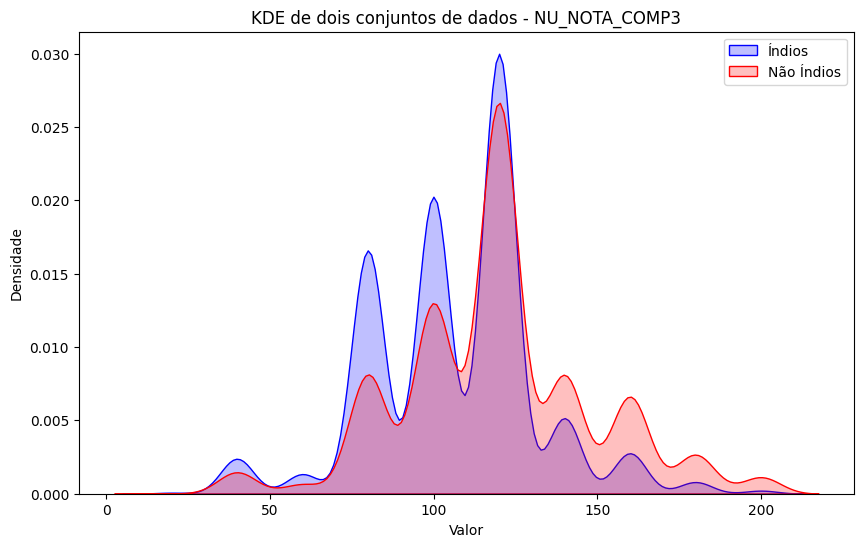

In [37]:
# Criar o gráfico KDE para NU_NOTA_COMP3
plt.figure(figsize=(10, 6))
sns.kdeplot(df22[df22['TP_COR_RACA_5']==True]['NU_NOTA_COMP3'], color='blue', shade=True, label='Índios')
sns.kdeplot(df22[df22['TP_COR_RACA_5']==False]['NU_NOTA_COMP3'], color='red', shade=True, label='Não Índios')
plt.title('KDE de dois conjuntos de dados - NU_NOTA_COMP3')
plt.xlabel('Valor')
plt.ylabel('Densidade')
plt.legend()
plt.show()

C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\4181574789.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df22[df22[coluna]==True]['NU_NOTA_REDACAO'], color=cor, shade=True, label=label, bw_adjust=1.5)
C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\4181574789.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df22[df22[coluna]==True]['NU_NOTA_REDACAO'], color=cor, shade=True, label=label, bw_adjust=1.5)
C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\4181574789.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df22[df22[coluna]==True]['NU_NOTA_REDACAO'], color=cor, shade=True, label=label, bw_adjust=1.5

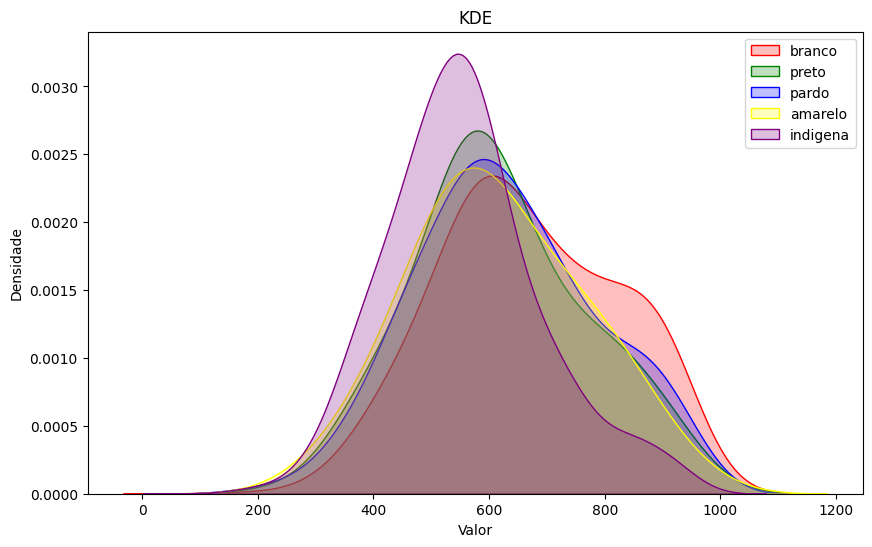

[1065, 496, 1759, 79, 3399]


In [38]:
# Definindo as cores e labels para cada grupo
cores = ['red', 'green', 'blue', 'yellow', 'purple']
labels = ['branco', 'preto', 'pardo', 'amarelo', 'indigena']
colunas_raca = ['TP_COR_RACA_1', 'TP_COR_RACA_2', 'TP_COR_RACA_3', 'TP_COR_RACA_4', 'TP_COR_RACA_5']

# Lista para armazenar os comprimentos
lengths = []

# Criar o gráfico KDE com Seaborn
plt.figure(figsize=(10, 6))

# Loop através das colunas de raça
for cor, label, coluna in zip(cores, labels, colunas_raca):
    sns.kdeplot(df22[df22[coluna]==True]['NU_NOTA_REDACAO'], color=cor, shade=True, label=label, bw_adjust=1.5)
    lengths.append(len(df22[df22[coluna]==True]['NU_NOTA_REDACAO']))

# Adicionar título e rótulos
plt.title('KDE')
plt.xlabel('Valor')
plt.ylabel('Densidade')

# Adicionar legenda
plt.legend()

# Mostrar o gráfico
plt.show()

print(lengths)

C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\2961378365.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22, x='TP_COR_RACA_5', y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


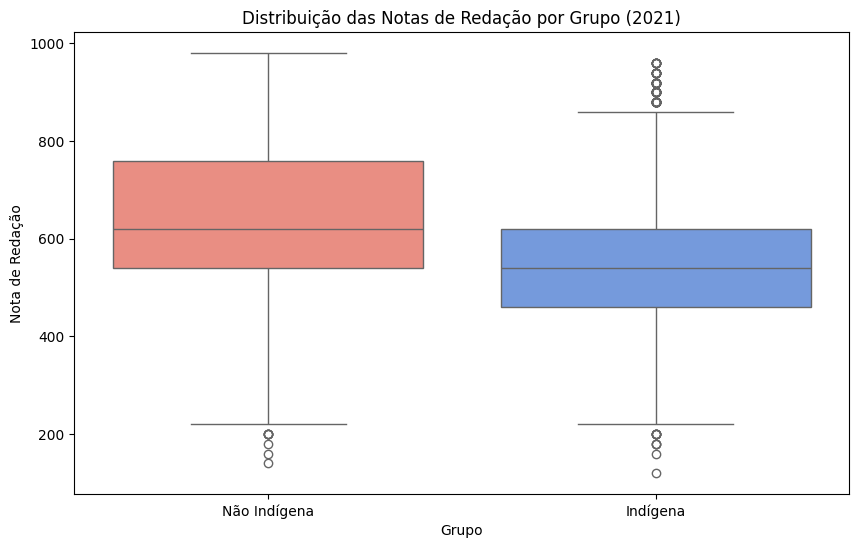

In [39]:
# Boxplot das notas de redação
# O tema de 2021 sobre comunidades tradicionais não parece ter tido um impacto significativo nas notas de redação dos estudantes indígenas comparado aos anos anteriores e seguintes.
plt.figure(figsize=(10, 6))
sns.boxplot(data=df22, x='TP_COR_RACA_5', y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])
plt.title('Distribuição das Notas de Redação por Grupo (2021)')
plt.xlabel('Grupo')
plt.ylabel('Nota de Redação')
plt.xticks([0, 1], ['Não Indígena', 'Indígena'])
plt.show()

C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\48878497.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22, x='Q025', y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


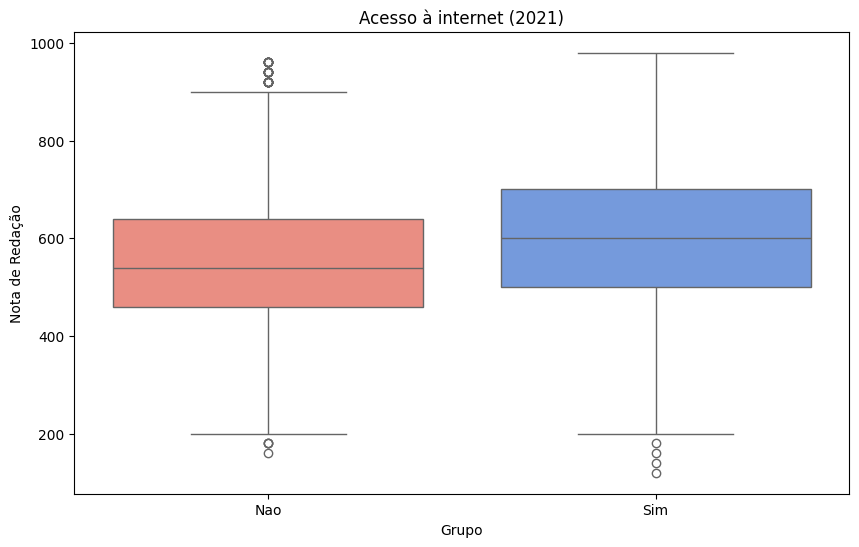

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df22, x='Q025', y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])
plt.title('Acesso à internet (2021)')
plt.xlabel('Grupo')
plt.ylabel('Nota de Redação')
plt.xticks([0, 1], ['Nao', 'Sim'])
plt.show()

In [41]:
print(df22.columns)

Index(['NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESCOLA', 'NU_NOTA_CN',
       'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_COMP1',
       'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_REDACAO', 'Q022', 'Q025',
       'TP_COR_RACA_1', 'TP_COR_RACA_2', 'TP_COR_RACA_3', 'TP_COR_RACA_4',
       'TP_COR_RACA_5', 'CAPITAL', 'Regiao_Centro-Oeste', 'Regiao_Nordeste',
       'Regiao_Norte', 'Regiao_Sudeste', 'Regiao_Sul', 'renda_fam',
       'maior_escolaridade', 'maior_emprego'],
      dtype='object')


In [42]:
# df22['TP_FAIXA_ETARIA'] = df22['TP_FAIXA_ETARIA'].apply(lambda x: 1 if x < 2 else x) # menores de 18
# df22['TP_FAIXA_ETARIA'] = df22['TP_FAIXA_ETARIA'].apply(lambda x: 3 if x == 3 or x == 4 else x) # 19 - 20 anos
# df22['TP_FAIXA_ETARIA'] = df22['TP_FAIXA_ETARIA'].apply(lambda x: 4 if x == 5 or x == 6 or x == 7 else x) # 21 - 23 anos
# df22['TP_FAIXA_ETARIA'] = df22['TP_FAIXA_ETARIA'].apply(lambda x: 5 if x == 8 or x == 9 or x == 10 else x) # 24 - 30 anos
df22['TP_FAIXA_ETARIA'] = df22['TP_FAIXA_ETARIA'].apply(lambda x: 6 if x > 5 else x) # 31+
print(df22['TP_FAIXA_ETARIA'].value_counts())

TP_FAIXA_ETARIA
2    2922
1    2520
3     800
4     264
6     136
0      86
5      70
Name: count, dtype: int64


In [43]:
df22['renda_fam'] = df22['renda_fam'].apply(lambda x: 7 if x > 6 else x) # 31+
print(df22['renda_fam'].value_counts())

renda_fam
2    2342
1    2252
0     848
3     570
4     370
5     182
7     126
6     108
Name: count, dtype: int64


C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])
C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: UserWarning: 
The palette list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


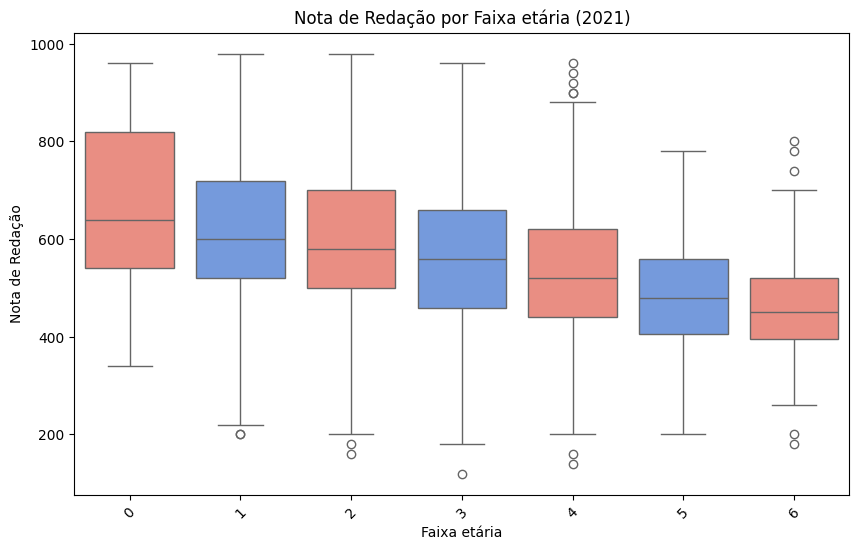

C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


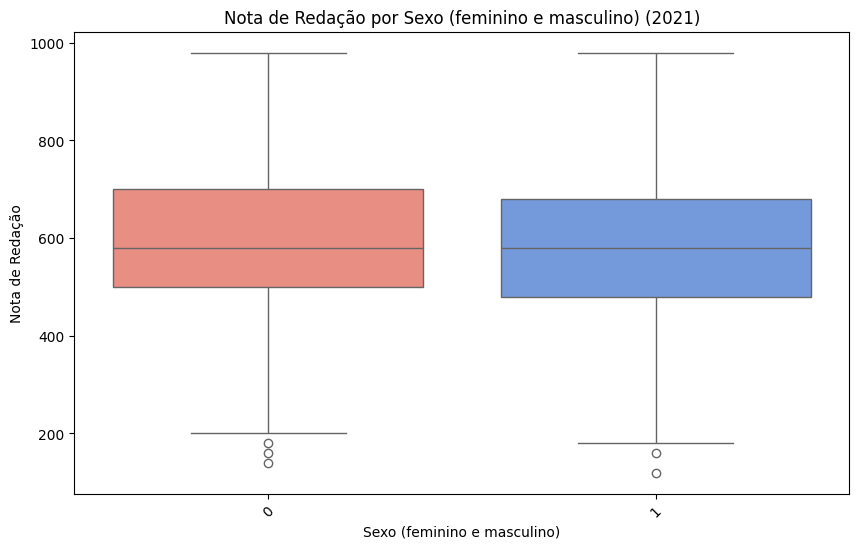

C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


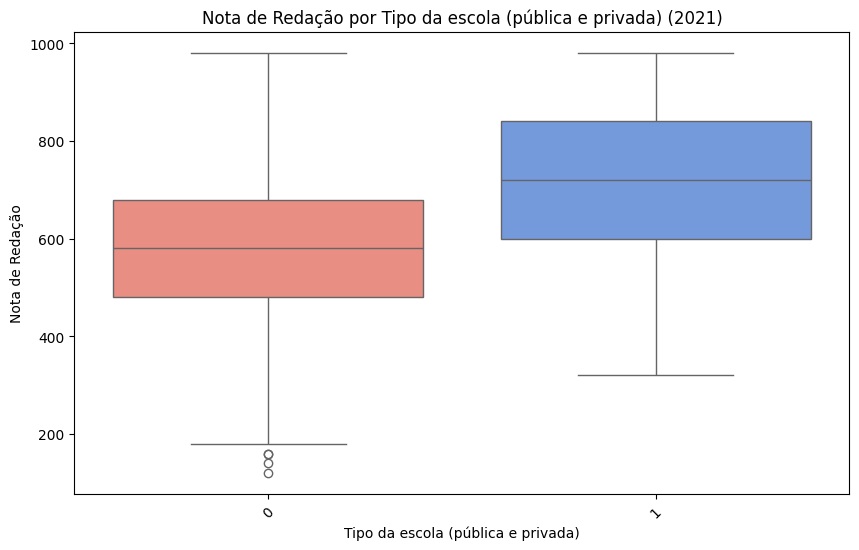

C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])
C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


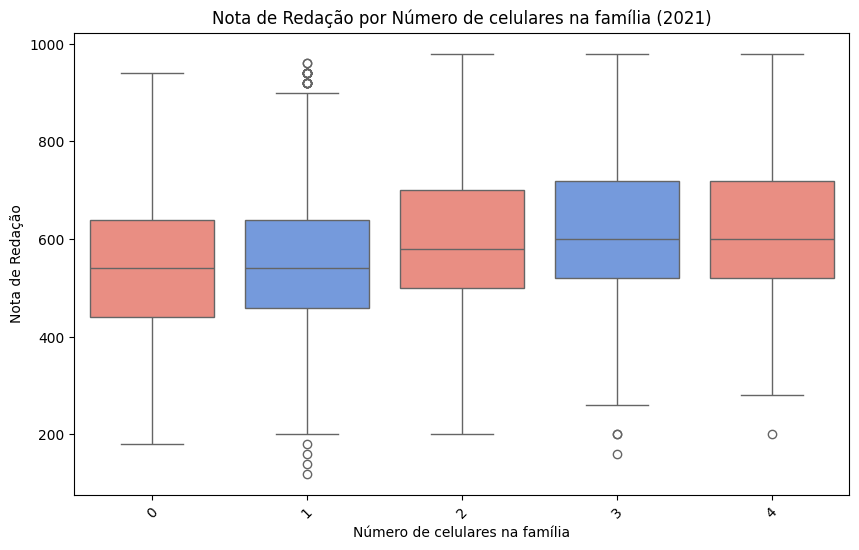

C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


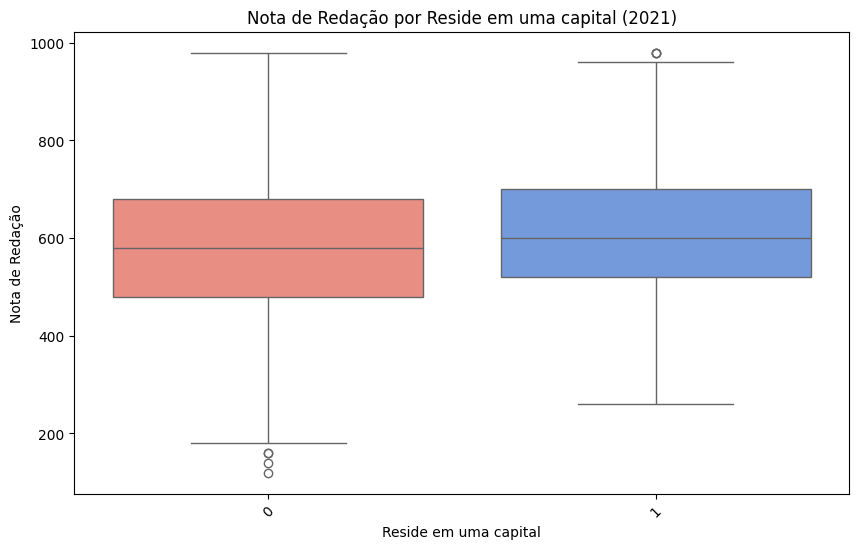

C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])
C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: UserWarning: 
The palette list has fewer values (2) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


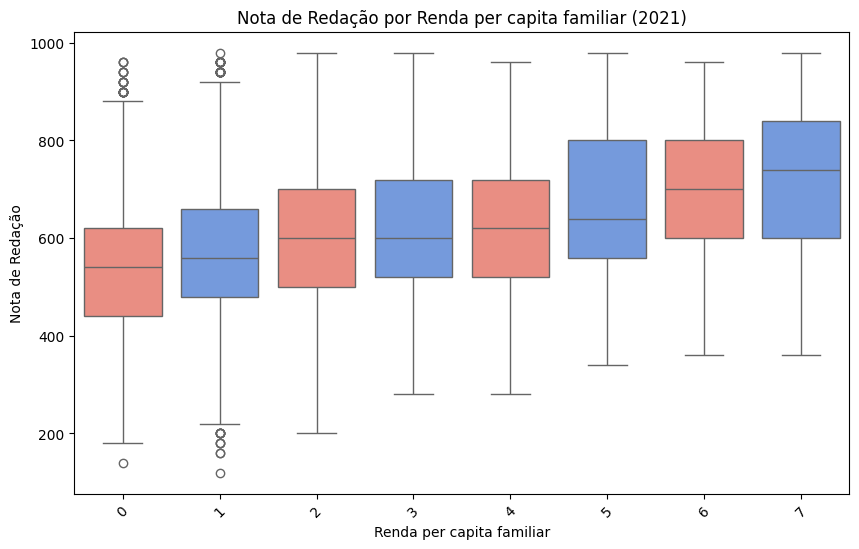

C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])
C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: UserWarning: 
The palette list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


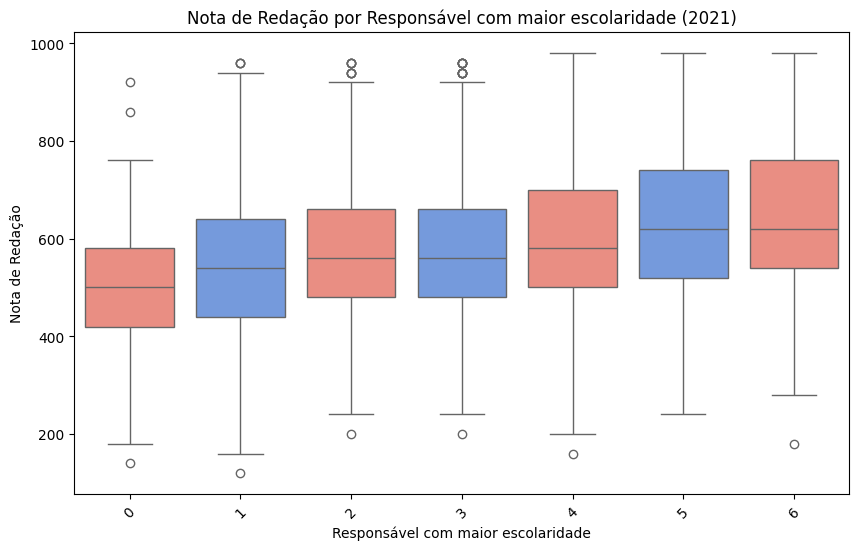

C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])
C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


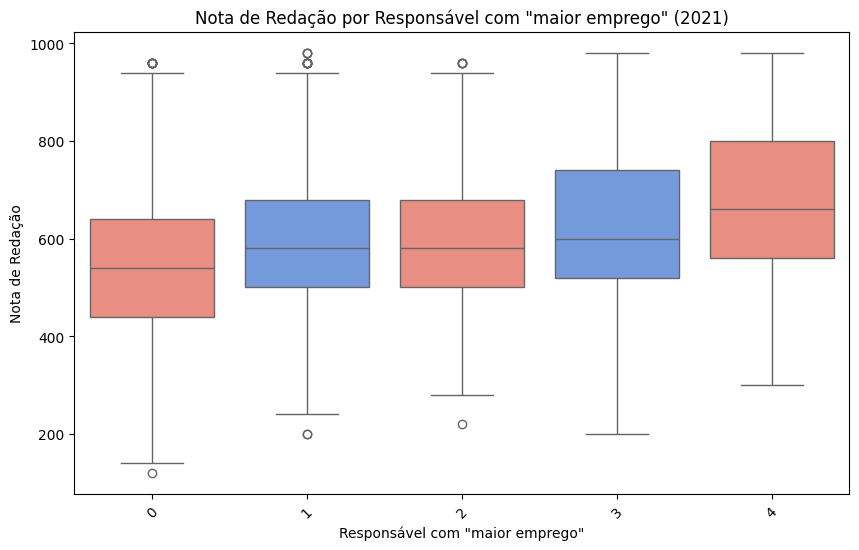

C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


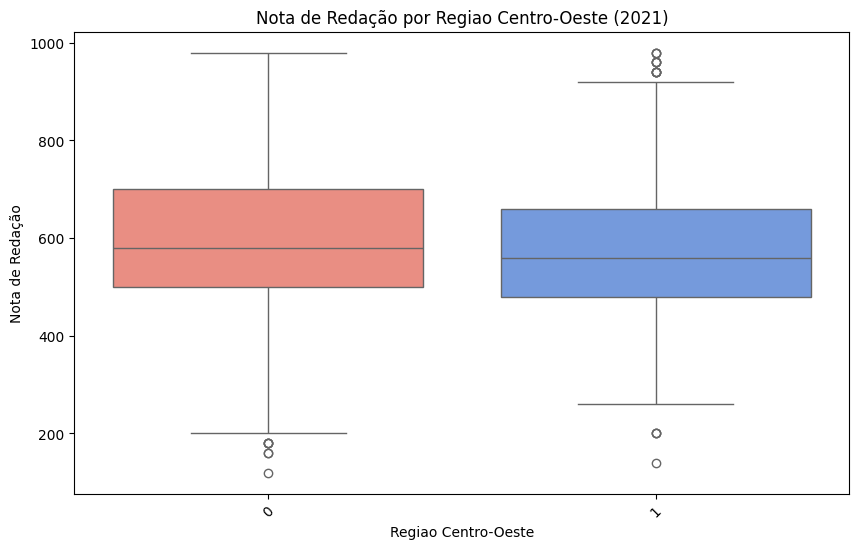

C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


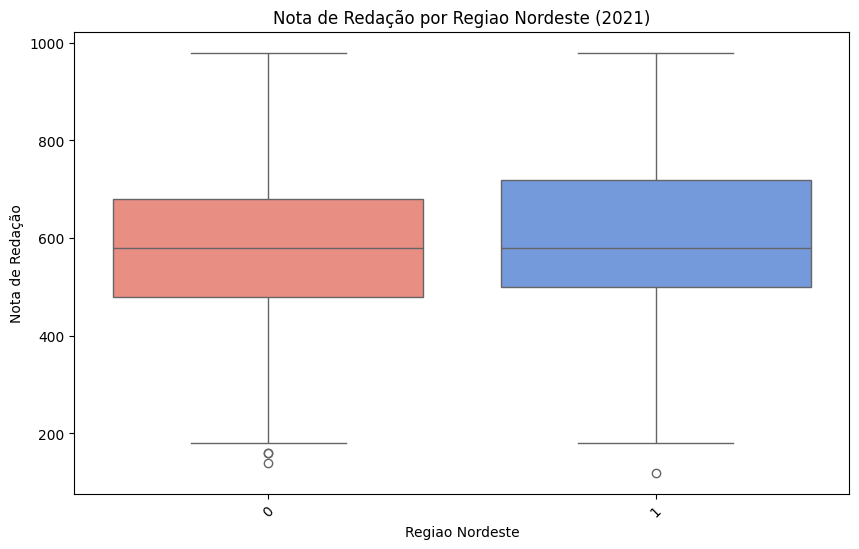

C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


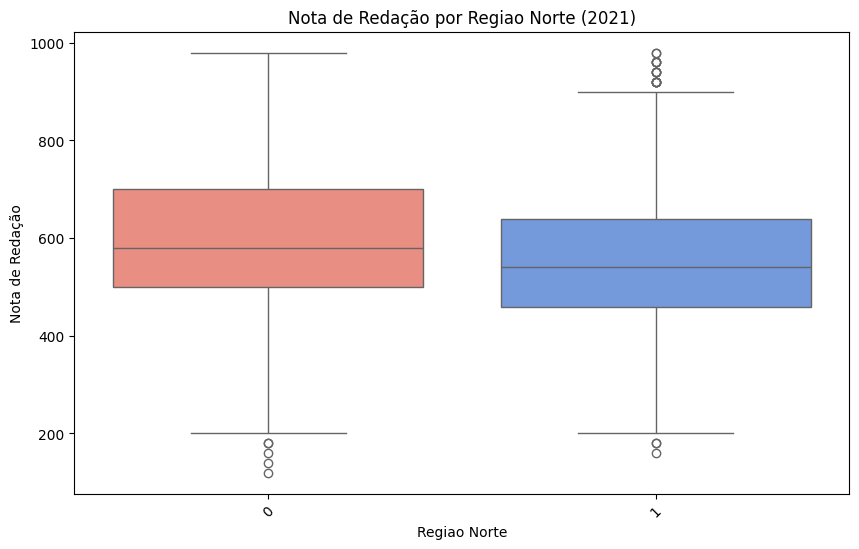

C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


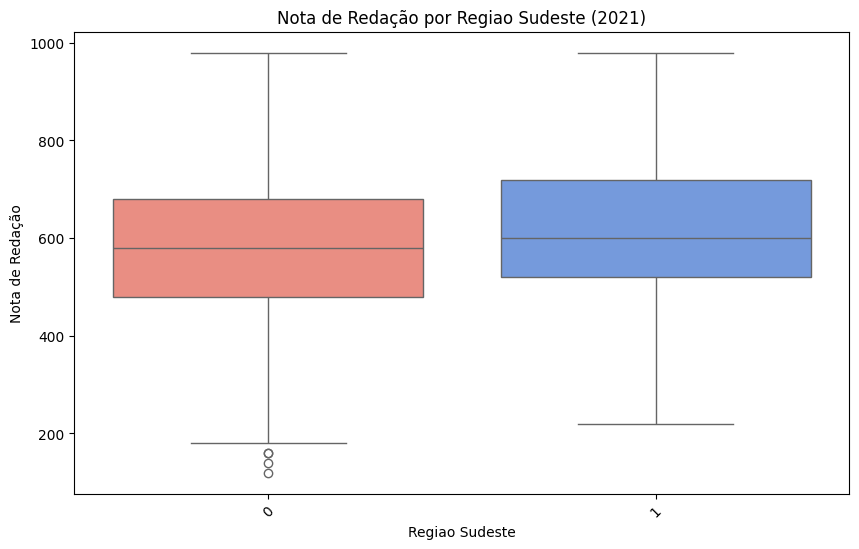

C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\354322480.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])


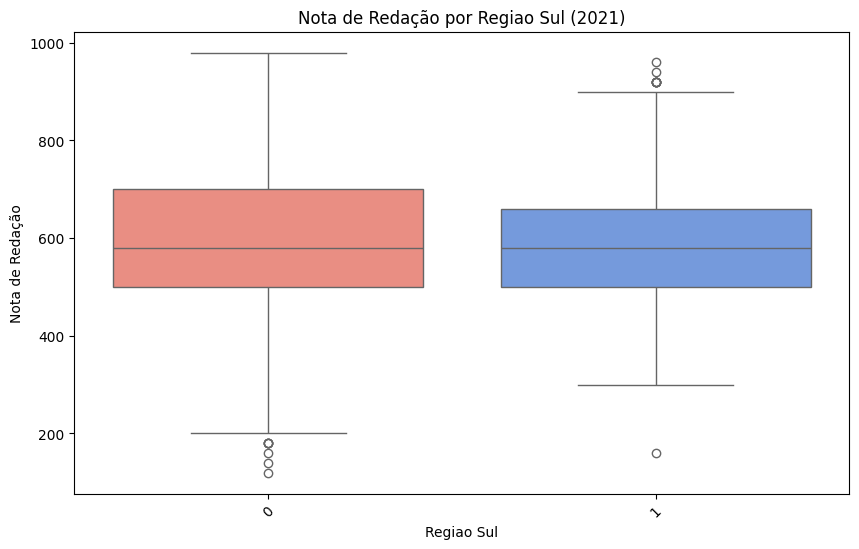

In [44]:
# Lista de variáveis de interesse para o eixo x
variaveis = ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESCOLA', 'Q022', 'CAPITAL', 'renda_fam',
       'maior_escolaridade', 'maior_emprego', 'Regiao_Centro-Oeste', 'Regiao_Nordeste', 'Regiao_Norte',
       'Regiao_Sudeste', 'Regiao_Sul']
variaveis_nomes = ['Faixa etária', 'Sexo (feminino e masculino)', 'Tipo da escola (pública e privada)',
                    'Número de celulares na família', 'Reside em uma capital', 'Renda per capita familiar', 'Responsável com maior escolaridade',
                     'Responsável com "maior emprego"', 'Regiao Centro-Oeste', 'Regiao Nordeste', 'Regiao Norte', 'Regiao Sudeste', 'Regiao Sul']

# Loop para criar e exibir cada gráfico separadamente
for i, variavel in enumerate(variaveis):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df22, x=variavel, y='NU_NOTA_REDACAO', palette=['salmon', 'cornflowerblue'])
    plt.title(f'Nota de Redação por {variaveis_nomes[i]} (2021)')
    plt.xlabel(variaveis_nomes[i])
    plt.ylabel('Nota de Redação')
    plt.xticks(rotation=45)  # Rotação dos rótulos se necessário
    plt.show()


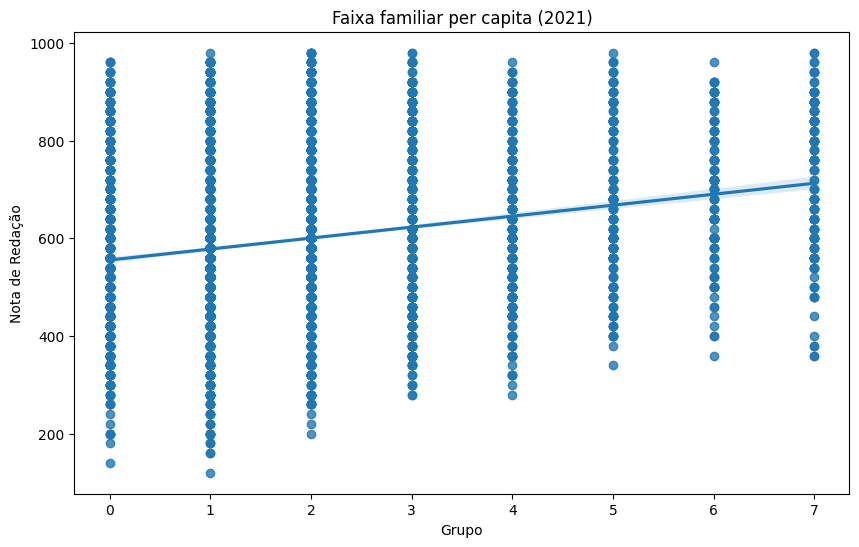

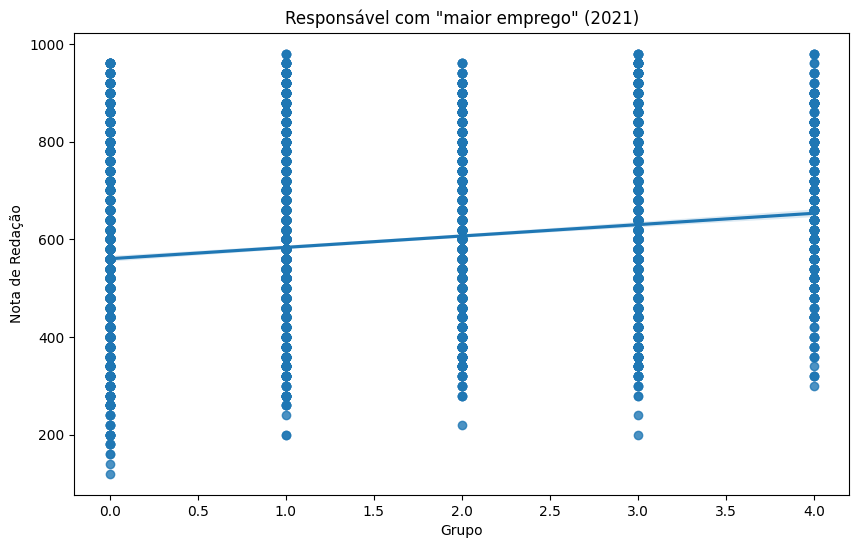

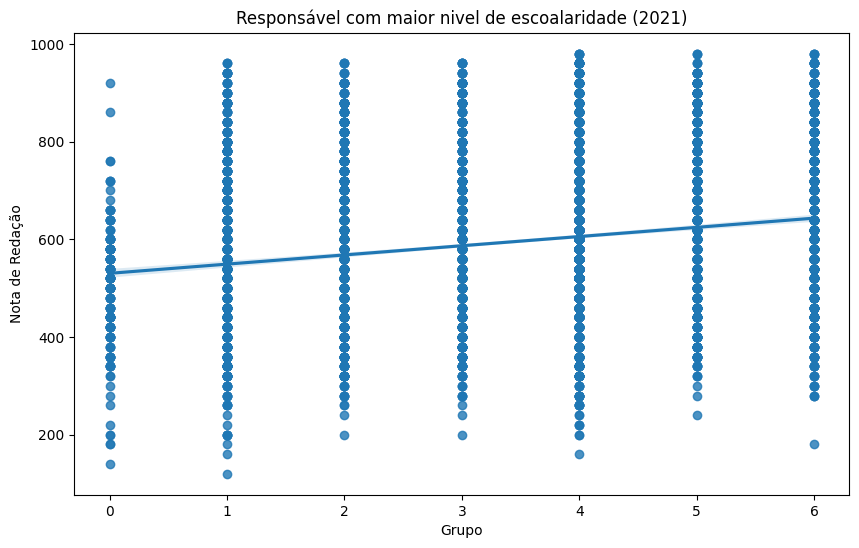

In [45]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df22, x='renda_fam', y='NU_NOTA_REDACAO')
plt.title('Faixa familiar per capita (2021)')
plt.xlabel('Grupo')
plt.ylabel('Nota de Redação')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(data=df22, x='maior_emprego', y='NU_NOTA_REDACAO')
plt.title('Responsável com "maior emprego" (2021)')
plt.xlabel('Grupo')
plt.ylabel('Nota de Redação')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(data=df22, x='maior_escolaridade', y='NU_NOTA_REDACAO')
plt.title('Responsável com maior nivel de escoalaridade (2021)')
plt.xlabel('Grupo')
plt.ylabel('Nota de Redação')
plt.show()

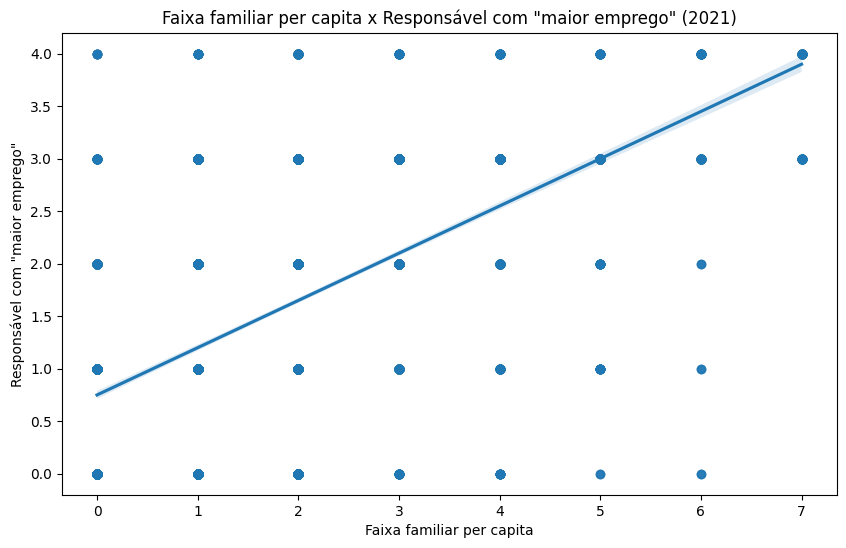

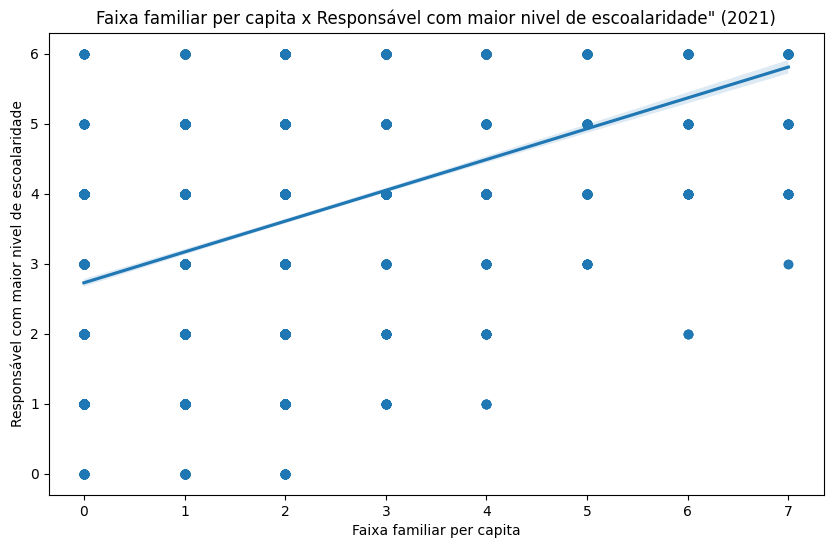

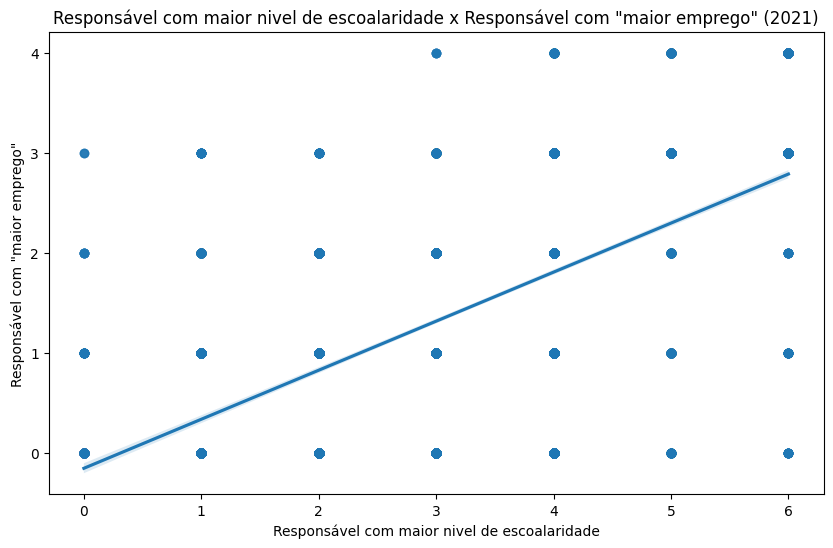

In [46]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df22, x='renda_fam', y='maior_emprego')
plt.title('Faixa familiar per capita x Responsável com "maior emprego" (2021)')
plt.xlabel('Faixa familiar per capita')
plt.ylabel('Responsável com "maior emprego"')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(data=df22, x='renda_fam', y='maior_escolaridade')
plt.title('Faixa familiar per capita x Responsável com maior nivel de escoalaridade" (2021)')
plt.xlabel('Faixa familiar per capita')
plt.ylabel('Responsável com maior nivel de escoalaridade')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(data=df22, x='maior_escolaridade', y='maior_emprego')
plt.title('Responsável com maior nivel de escoalaridade x Responsável com "maior emprego" (2021)')
plt.xlabel('Responsável com maior nivel de escoalaridade')
plt.ylabel('Responsável com "maior emprego"')
plt.show()

A análise das correlações ajuda na regressão linear de várias maneiras:

*Identificação de Variáveis Relevantes*: Ao examinar as correlações entre as variáveis independentes e a variável dependente, você pode identificar quais variáveis têm uma relação mais forte com a variável de interesse. Isso ajuda na seleção das variáveis a serem incluídas no modelo de regressão.

*Prevenção de Multicolinearidade*: A análise das correlações entre as variáveis independentes pode ajudar a identificar a multicolinearidade, que ocorre quando duas ou mais variáveis independentes estão altamente correlacionadas entre si. A multicolinearidade pode prejudicar a interpretação dos coeficientes de regressão e a precisão das previsões.

*Validação de Suposiçõe*s: A regressão linear assume certas condições, como linearidade, homocedasticidade e independência dos erros. Ao examinar as correlações, você pode verificar se essas suposições estão sendo violadas. Por exemplo, se houver uma correlação não linear entre as variáveis, pode ser necessário considerar transformações das variáveis.

*Interpretação dos Coeficientes*: As correlações podem fornecer insights sobre a direção e a magnitude das associações entre as variáveis independentes e a variável dependente. Isso ajuda na interpretação dos coeficientes de regressão no modelo final.

Em resumo, a análise das correlações é uma etapa importante no processo de modelagem de regressão linear, pois ajuda a selecionar variáveis relevantes, evitar problemas como multicolinearidade e validar suposições do modelo. Isso leva a um modelo de regressão mais robusto e confiável.

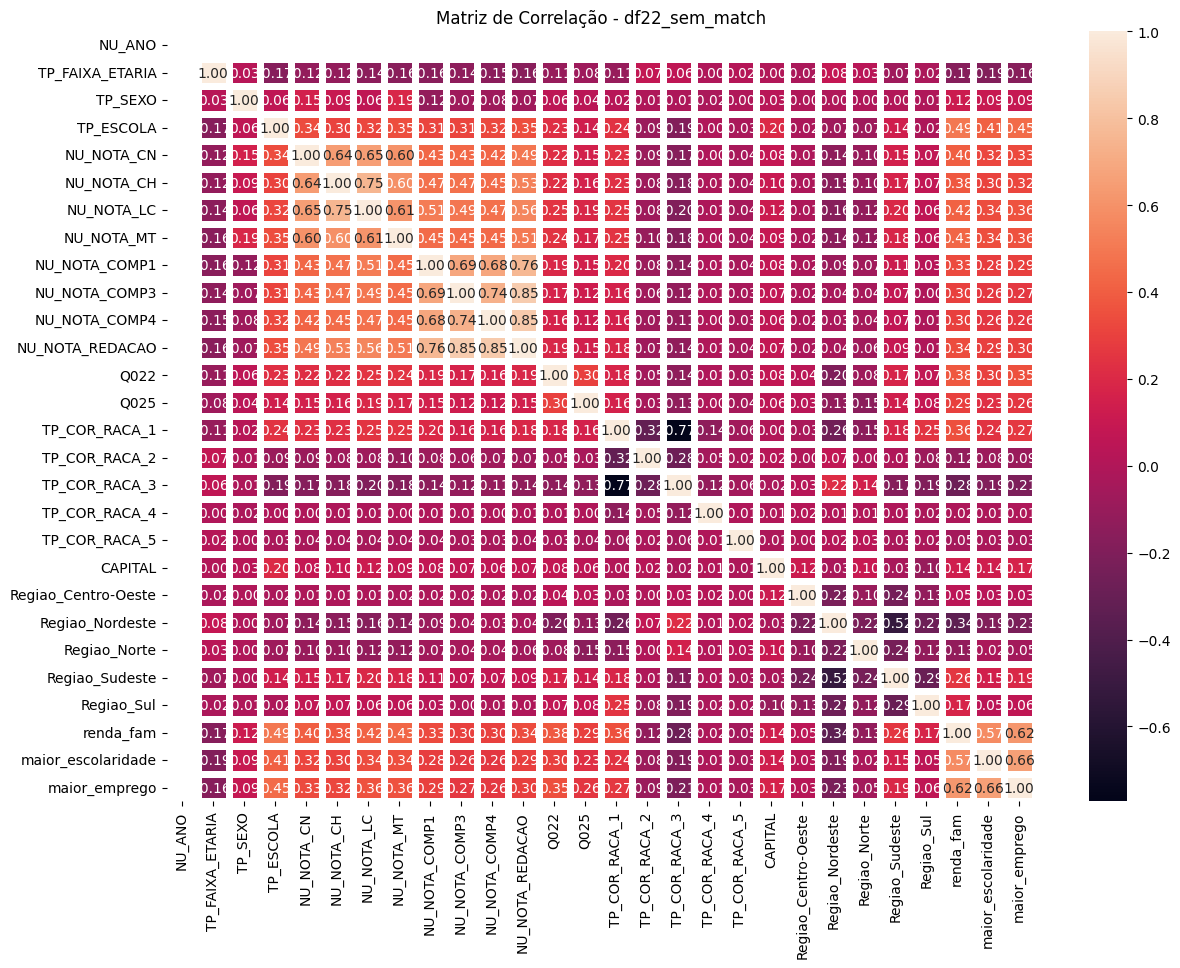

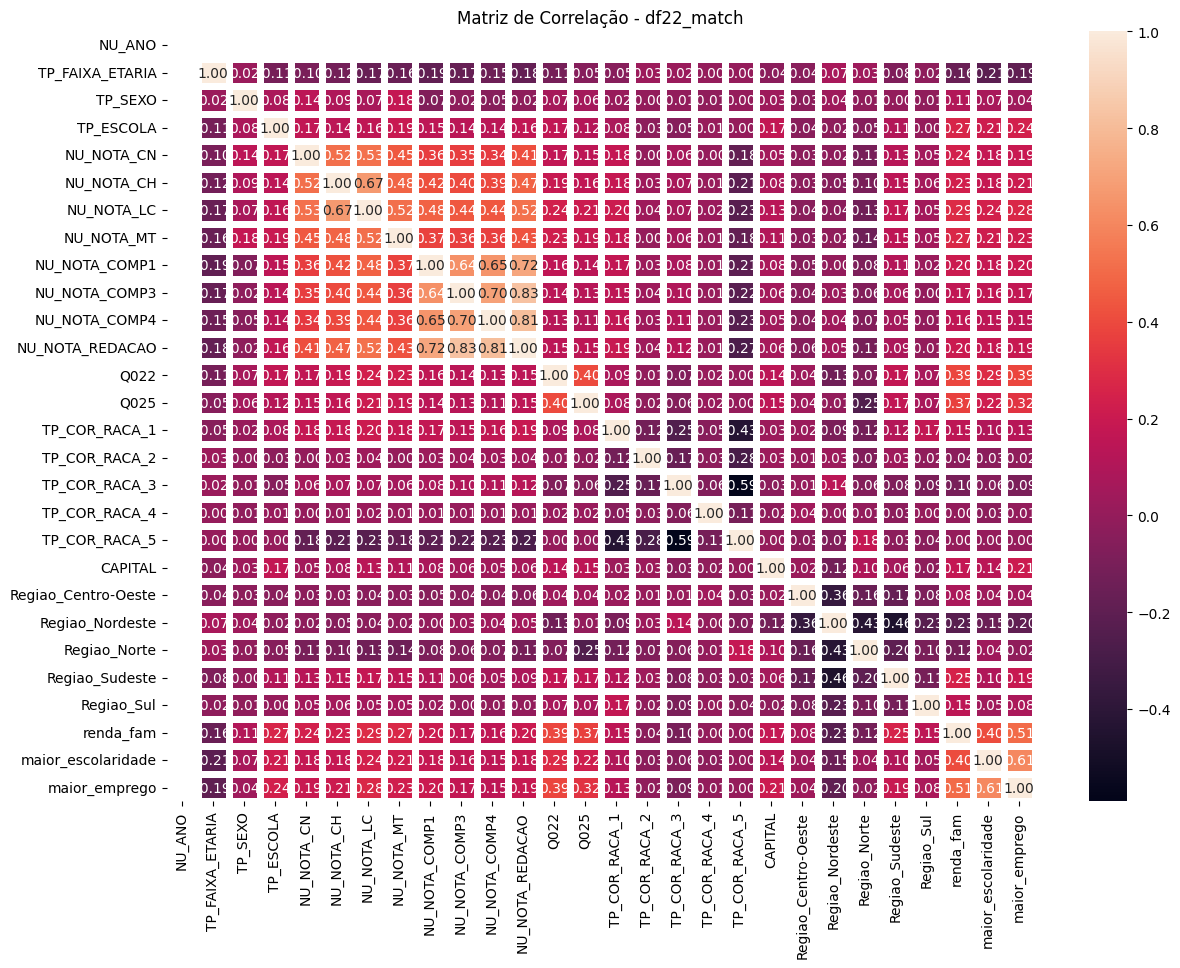

In [47]:
# nota-se que a correlação da cor/raça indigena com a nota da redação foi menos negativa em 22 e o valor da variavel indio se torna mais significativa

plt.figure(figsize=(14, 10))
# Plot da matriz de correlação para df22
plot1 = sns.heatmap(df22_sem_match.corr(method='spearman'), annot=True, fmt="0.2f", linewidths=5)
plt.title('Matriz de Correlação - df22_sem_match')
# Exibir o plot1
plt.show()


plt.figure(figsize=(14, 10))
# Plot da matriz de correlação para df22_match
plot2 = sns.heatmap(df22.corr(method='spearman'), annot=True, fmt="0.2f", linewidths=5)
plt.title('Matriz de Correlação - df22_match')
# Exibir o plot2
plt.show()

# Modelos

Modelos:
* regressão linear x multinivel
* nota da redação x nota da competencia 3
* todas as variaveis
* variaveis relevantes
* exlcuindo as com correlação muito alta
* indio ou nao-indio apenas


In [48]:
print(df22.columns)

Index(['NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESCOLA', 'NU_NOTA_CN',
       'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_COMP1',
       'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_REDACAO', 'Q022', 'Q025',
       'TP_COR_RACA_1', 'TP_COR_RACA_2', 'TP_COR_RACA_3', 'TP_COR_RACA_4',
       'TP_COR_RACA_5', 'CAPITAL', 'Regiao_Centro-Oeste', 'Regiao_Nordeste',
       'Regiao_Norte', 'Regiao_Sudeste', 'Regiao_Sul', 'renda_fam',
       'maior_escolaridade', 'maior_emprego'],
      dtype='object')


In [49]:
def combine_race(row):
    if row['TP_COR_RACA_1'] == 1:
        return '1'
    elif row['TP_COR_RACA_2'] == 1:
        return '2'
    elif row['TP_COR_RACA_3'] == 1:
        return '3'
    elif row['TP_COR_RACA_4'] == 1:
        return '4'
    elif row['TP_COR_RACA_5'] == 1:
        return '5'
    else:
        return 'Unknown'
    
def combine_regiao(row):
    if row['Regiao_Centro-Oeste'] == 1:
        return '1'
    elif row['Regiao_Nordeste'] == 1:
        return '2'
    elif row['Regiao_Norte'] == 1:
        return '3'
    elif row['Regiao_Sudeste'] == 1:
        return '4'
    elif row['Regiao_Sul'] == 1:
        return '5'
    else:
        return 'Unknown'

In [50]:
# Modelo 1: Regressao linear, nota da redação, todas as variaveis

df22_modelo1 = df22.copy()

df22_modelo1['TP_COR_RACA'] = df22_modelo1.apply(combine_race, axis=1)
df22_modelo1['Regiao'] = df22_modelo1.apply(combine_regiao, axis=1)

# Dividir os dados
train, test = train_test_split(df22_modelo1, test_size=0.2, random_state=42)

# Definir a fórmula da regressão, especificando que TP_COR_RACA é uma variável categórica
formula = 'NU_NOTA_REDACAO ~ TP_FAIXA_ETARIA + TP_SEXO + TP_ESCOLA + Q022 + Q025 + C(TP_COR_RACA) + C(Regiao) \
    + CAPITAL + renda_fam + maior_escolaridade + maior_emprego'

# Ajustar o modelo de regressão linear usando os dados de treinamento
model = smf.ols(formula, data=train).fit()

# Exibir os resultados
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        NU_NOTA_REDACAO   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     75.28
Date:                Sun, 23 Jun 2024   Prob (F-statistic):          5.37e-234
Time:                        11:17:42   Log-Likelihood:                -34451.
No. Observations:                5438   AIC:                         6.894e+04
Df Residuals:                    5420   BIC:                         6.906e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             593.4308    

In [51]:
# Modelo 2: Regressao linear, nota da redação, excluindo com correlação muito baixa com a variavel resposta (sexo, ano que concluiu, capital)

# ainda usando df22_modelo1

# Definir a fórmula da regressão, especificando que TP_COR_RACA é uma variável categórica
formula = 'NU_NOTA_REDACAO ~ TP_FAIXA_ETARIA + Q022 + Q025 + C(TP_COR_RACA) + C(Regiao) \
    + renda_fam + maior_escolaridade + maior_emprego'

# Ajustar o modelo de regressão linear usando os dados de treinamento
model = smf.ols(formula, data=train).fit()

# Exibir os resultados
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        NU_NOTA_REDACAO   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     86.51
Date:                Sun, 23 Jun 2024   Prob (F-statistic):          8.49e-225
Time:                        11:17:43   Log-Likelihood:                -34479.
No. Observations:                5438   AIC:                         6.899e+04
Df Residuals:                    5423   BIC:                         6.909e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             584.9796    

In [52]:
# Modelo 3: Regressao linear, nota da redação, excluindo com correlação muito alta com a variavel independente (ano que concluiu, renda familiar per capita, responsavel de maior emprego)

# ainda usando df22_modelo1

# Definir a fórmula da regressão, especificando que TP_COR_RACA é uma variável categórica
formula = 'NU_NOTA_REDACAO ~ TP_FAIXA_ETARIA + TP_SEXO + Q022 + Q025 + C(TP_COR_RACA) + C(Regiao) \
    + CAPITAL + maior_escolaridade'
# Ajustar o modelo de regressão linear usando os dados de treinamento
model = smf.ols(formula, data=train).fit()

# Exibir os resultados
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        NU_NOTA_REDACAO   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     81.23
Date:                Sun, 23 Jun 2024   Prob (F-statistic):          1.02e-211
Time:                        11:17:43   Log-Likelihood:                -34509.
No. Observations:                5438   AIC:                         6.905e+04
Df Residuals:                    5423   BIC:                         6.915e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             593.5066    

In [53]:
# Modelo 4: Regressao linear, nota da redação, indio ou nao indio apenas

df22_modelo4 = df22.copy()

df22_modelo4['Regiao'] = df22_modelo4.apply(combine_regiao, axis=1)

# Dividir os dados
train, test = train_test_split(df22_modelo4, test_size=0.2, random_state=42)

# Definir a fórmula da regressão, especificando que TP_COR_RACA é uma variável categórica
formula = 'NU_NOTA_REDACAO ~ TP_FAIXA_ETARIA + TP_SEXO + TP_ESCOLA + Q022 + Q025 + TP_COR_RACA_5 + C(Regiao) \
    + CAPITAL + renda_fam + maior_escolaridade + maior_emprego'

model = smf.ols(formula, data=train).fit()

# Exibir os resultados
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        NU_NOTA_REDACAO   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     89.72
Date:                Sun, 23 Jun 2024   Prob (F-statistic):          1.15e-232
Time:                        11:17:43   Log-Likelihood:                -34461.
No. Observations:                5438   AIC:                         6.895e+04
Df Residuals:                    5423   BIC:                         6.905e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            574.9319      9

In [54]:
import statsmodels.formula.api as smf
import numpy as np

# Definição da fórmula
formula = 'NU_NOTA_REDACAO ~ TP_FAIXA_ETARIA + TP_SEXO + TP_ESCOLA + Q022 + Q025 + TP_COR_RACA_5 + C(Regiao) \
    + CAPITAL + renda_fam + maior_escolaridade + maior_emprego + NU_NOTA_LC + NU_NOTA_CH + NU_NOTA_MT'

# Criação de uma cópia do DataFrame
df_multinivel = df22.copy()

df_multinivel['Regiao'] = df_multinivel.apply(combine_regiao, axis=1)

# Ajustar o modelo multinível
model_multinivel = smf.mixedlm(formula, data=df_multinivel, groups=df_multinivel['TP_COR_RACA_5']).fit()

# Exibir os resultados
print(model_multinivel.summary())

# Predição dos valores ajustados
y_pred = model_multinivel.fittedvalues

# Valores reais
y_real = df_multinivel['NU_NOTA_REDACAO']

# Cálculo do R²
ss_total = np.sum((y_real - np.mean(y_real)) ** 2)
ss_residual = np.sum((y_real - y_pred) ** 2)
r_squared = 1 - (ss_residual / ss_total)

# Cálculo do erro absoluto
mae = np.mean(np.abs(y_real - y_pred))

print(f'R²: {r_squared}')
print(f'Mean Absolute Error: {mae}')


               Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   NU_NOTA_REDACAO
No. Observations:    6798      Method:               REML           
No. Groups:          2         Scale:                13880.4814     
Min. group size:     3399      Log-Likelihood:       -42037.7773    
Max. group size:     3399      Converged:            Yes            
Mean group size:     3399.0                                         
--------------------------------------------------------------------
                     Coef.   Std.Err.    z    P>|z|  [0.025   0.975]
--------------------------------------------------------------------
Intercept             51.106  118.533   0.431 0.666 -181.214 283.427
C(Regiao)[T.2]        33.234    4.687   7.090 0.000   24.047  42.422
C(Regiao)[T.3]        23.056    5.670   4.067 0.000   11.944  34.168
C(Regiao)[T.4]         4.707    5.403   0.871 0.384   -5.884  15.297
C(Regiao)[T.5]       -19.913    7.658  -2.600 0.00

C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [55]:
print(df22.columns)

Index(['NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESCOLA', 'NU_NOTA_CN',
       'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_COMP1',
       'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_REDACAO', 'Q022', 'Q025',
       'TP_COR_RACA_1', 'TP_COR_RACA_2', 'TP_COR_RACA_3', 'TP_COR_RACA_4',
       'TP_COR_RACA_5', 'CAPITAL', 'Regiao_Centro-Oeste', 'Regiao_Nordeste',
       'Regiao_Norte', 'Regiao_Sudeste', 'Regiao_Sul', 'renda_fam',
       'maior_escolaridade', 'maior_emprego'],
      dtype='object')


In [56]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

X = df22[['NU_NOTA_CN',
       'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_COMP1', "NU_NOTA_COMP4", 'TP_COR_RACA_2','TP_COR_RACA_3','TP_COR_RACA_4','TP_COR_RACA_5']].copy()

Y = df22['NU_NOTA_REDACAO'].copy()

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.20, random_state=42)

reg = LinearRegression()
# Treinando o modelo
model1 =  reg.fit(X_train, y_train)
# Prevendo os dados de saída com o modelo treinado 
y_pred = model1.predict(X_test)
# Aqui plotamos os coeficientes da nossa regressão
reg.coef_

array([  0.05702094,   0.07837995,   0.12091405,   0.06535215,
         1.58838596,   2.96384878,  -0.49531419,   1.52828191,
       -12.89222619, -11.83184922])

In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = sm.add_constant(X)

# Calculando VIF
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif

,Variable,VIF
0,const,81.356514
1,NU_NOTA_CN,1.831651
2,NU_NOTA_CH,2.214784
3,NU_NOTA_LC,2.311488
4,NU_NOTA_MT,1.803617
5,NU_NOTA_COMP1,2.067320
6,NU_NOTA_COMP4,2.015767
7,TP_COR_RACA_2,1.381974
8,TP_COR_RACA_3,2.007829
9,TP_COR_RACA_4,1.065111


In [58]:
print( mean_squared_error(y_test, y_pred) )
print( mean_absolute_error(y_test, y_pred) )

4152.811535945967
49.622330399430766


In [59]:
df_saida = pd.DataFrame()
df_saida['y'] = y_test
df_saida['y_pred'] = y_pred

# Visualizando os dados previstos vs dados reais.
df_saida.head(100)

,y,y_pred
224,560.0,527.135243
317367,740.0,733.470236
16067,480.0,479.153395
22736,920.0,838.594770
5772,580.0,540.131602
...,...,...
346446,520.0,488.674971
511913,380.0,391.239278
310748,560.0,584.516788
327203,480.0,418.653379


In [60]:
# Importando Statsmodels para ter uma visão visão mais geral dos indicadores do modelo.
import statsmodels.api as sm

# Aqui estamos usando os mesmos dados anteriore de treino e teste. 
# O modelo resultante é exatamente o mesmo.
X_train=sm.add_constant(X_train)
m1 = sm.OLS( y_train, X_train)
m1 = m1.fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        NU_NOTA_REDACAO   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     2044.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        11:17:43   Log-Likelihood:                -30781.
No. Observations:                5438   AIC:                         6.158e+04
Df Residuals:                    5427   BIC:                         6.166e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -110.9118      8.514    -13.027      0.000    -127.603     -94.221
NU_NOTA_CN        0.0570      0.019      3.004      0.003       0.020       0.094
NU_NOTA_CH        0.0784      0.017      4.701      0.000       0.046       0.111
NU_NOTA_LC        0.1209      0.020      6.051      0.000       0.082       0.160
NU_NOTA_MT        0.0654      0.014      4.718      0.000       0.038       0.093
NU_NOTA_COMP1     1.5884      0.052     30.617      0.000       1.487       1.690
NU_NOTA_COMP4     2.9638      0.045     65.794      0.000       2.876       3.052
TP_COR_RACA_2    -0.4953      4.281     -0.116      0.908      -8.888       7.897
TP_COR_RACA_3     1.5283      3.053      0.501      0.617      -4.457       7.513
TP_COR_RACA_4   -12.8922      9.038     -1.426      0.154     -30.610       4.826
TP_COR_RACA_5   -11.8318      2.864     -4.131      0.000     -17.446      -6.218
==============================================================================
Omnibus:                      623.421   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1374.774
Skew:                          -0.699   Prob(JB):                    2.96e-299
Kurtosis:                       5.029   Cond. No.                     1.01e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

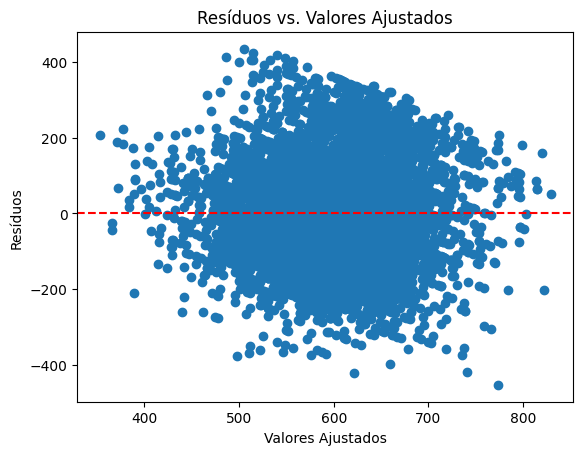

In [61]:
import matplotlib.pyplot as plt

# Plot dos resíduos vs valores ajustados
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Valores Ajustados')
plt.show()


In [62]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Teste de Breusch-Pagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
names = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
bp_test_results = dict(zip(names, bp_test))
print(bp_test_results)


{'LM Statistic': 108.14449474303663, 'LM-Test p-value': 1.2800834335120583e-16, 'F-Statistic': 7.859601908170747, 'F-Test p-value': 8.536363372936256e-17}


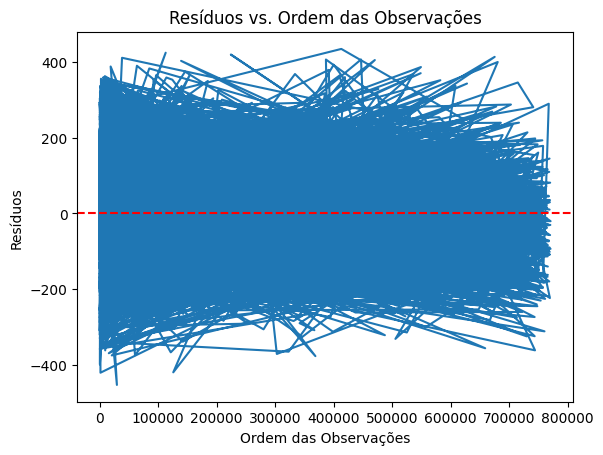

In [63]:
plt.plot(model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Ordem das Observações')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Ordem das Observações')
plt.show()


In [64]:
from statsmodels.stats.stattools import durbin_watson

# Teste de Durbin-Watson
dw_stat = durbin_watson(model.resid)
print('Durbin-Watson statistic:', dw_stat)


Durbin-Watson statistic: 1.9633239382988348


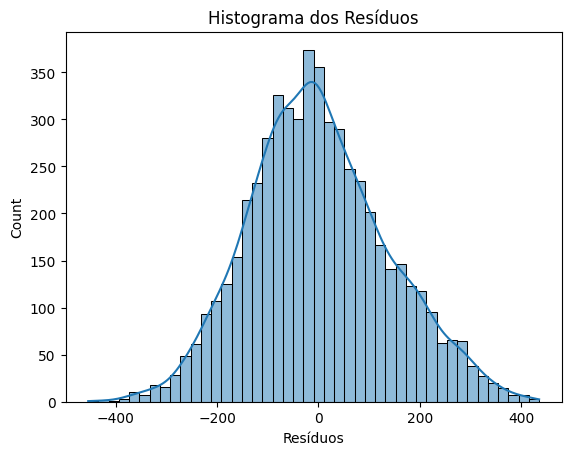

In [65]:
import seaborn as sns

sns.histplot(model.resid, kde=True)
plt.xlabel('Resíduos')
plt.title('Histograma dos Resíduos')
plt.show()


In [66]:
from statsmodels.stats.stattools import jarque_bera

# Teste de Jarque-Bera
jb_test = jarque_bera(model.resid)
names = ['Jarque-Bera Statistic', 'JB p-value', 'Skewness', 'Kurtosis']
jb_test_results = dict(zip(names, jb_test))
print(jb_test_results)


{'Jarque-Bera Statistic': 49.30489679775792, 'JB p-value': 1.9659736603583388e-11, 'Skewness': 0.2301977988599847, 'Kurtosis': 2.9249167281657336}


C:\Users\rafae\AppData\Local\Temp\ipykernel_29024\2242379377.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Linha de Referência')


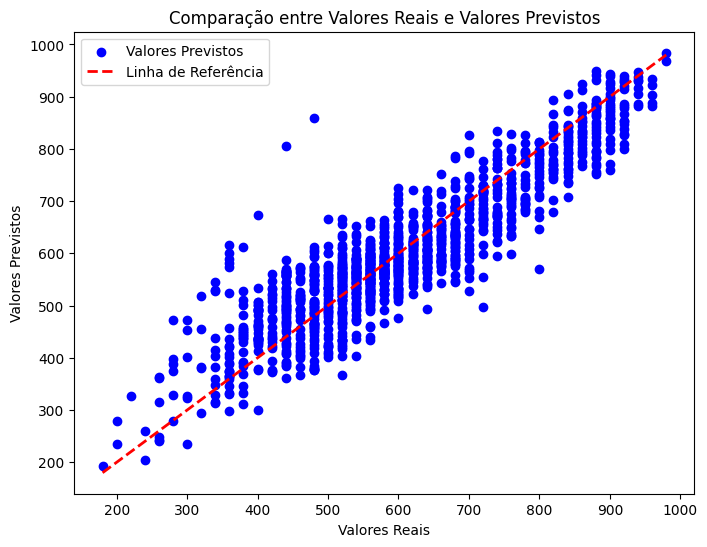

In [67]:
import matplotlib.pyplot as plt

# Plotando os valores reais vs previsões
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Valores Previstos')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Linha de Referência')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Comparação entre Valores Reais e Valores Previstos')
plt.legend()
plt.show()

In [68]:
from sklearn.preprocessing import StandardScaler

X_orig=X.values
Y_orig=Y.values

# Vamos padronizar os dados 
Xscaler=StandardScaler()
Yscaler=StandardScaler()
 
# Armazenar parâmetros
XscalerFit=Xscaler.fit(X_orig)
YscalerFit=Yscaler.fit(Y_orig.reshape(-1, 1))
 
# Gerar valores padronizados de X e y
X_pad=XscalerFit.transform(X_orig)
Y_pad=YscalerFit.transform(Y_orig.reshape(-1, 1))

In [69]:
# Separar os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split( X_pad, Y_pad, test_size=0.20, random_state=42)

X_trainols=sm.add_constant(X_train)
m1 = sm.OLS( y_train, X_trainols)
m1 = m1.fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     2044.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        11:17:44   Log-Likelihood:                -3478.8
No. Observations:                5438   AIC:                             6980.
Df Residuals:                    5427   BIC:                             7052.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0037      0.006     -0.593      0.553      -0.016       0.009
x1          1.161e-16   5.67e-18     20.464      0.000    1.05e-16    1.27e-16
x2             0.0253      0.008      3.004      0.003       0.009       0.042
x3             0.0429      0.009      4.701      0.000       0.025       0.061
x4             0.0568      0.009      6.051      0.000       0.038       0.075
x5             0.0392      0.008      4.718      0.000       0.023       0.056
x6             0.2725      0.009     30.617      0.000       0.255       0.290
x7             0.5801      0.009     65.794      0.000       0.563       0.597
x8            -0.0009      0.007     -0.116      0.908      -0.015       0.014
x9             0.0044      0.009      0.501      0.617      -0.013       0.022
x10           -0.0091      0.006     -1.426      0.154      -0.022       0.003
x11           -0.0390      0.009     -4.131      0.000      -0.058      -0.021
==============================================================================
Omnibus:                      623.421   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1374.774
Skew:                          -0.699   Prob(JB):                    2.96e-299
Kurtosis:                       5.029   Cond. No.                     1.25e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.29e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [70]:
# df22.to_csv('df21', index=False)